# Screen Modelling And Clustering for ASD

In [1]:
import sqlite3
from sqlite3 import Error
from sqlite3 import IntegrityError
from ipyfilechooser import FileChooser
import matplotlib.pyplot as plt
import pandas as pd
import io
import requests
import numpy
import seaborn as sns
from scipy import stats
import math
from scipy.stats import ttest_ind
from tqdm import tqdm

## Clustering Playtest

The below cells are for exploring clustering functionalities. Currently under development.

In [2]:
conn = sqlite3.connect('/Users/Joseph/Desktop/NRSC510B/mwt_data.db')
tstat_gene = pd.read_sql_query(f"SELECT * FROM tstat_gene_data", conn)
conn.close()

In [3]:
data = tstat_gene.drop(tstat_gene[tstat_gene.Gene == "N2"].index)
data = data.drop(columns=['Spontaneous Recovery of Response Duration',
                          'Spontaneous Recovery of Response Probability',
                          'Spontaneous Recovery of Response Speed'])
data_na = data.dropna().reset_index().drop(columns=['index'])
data_na.head(10)

Gene     Width    Length      Area  Instantaneous Speed  \
0    C29E4.10 -0.647055 -0.185658 -0.439891             0.902499   
1    F32D8.13  0.777410  0.113354  0.436028            -0.246369   
2     F53B2.5 -0.301572 -0.184646 -0.406214             2.560500   
3    F54B11.5 -0.833726 -0.436230 -0.755943             0.667368   
4     F55C5.7 -0.735903 -1.264234 -0.681969            -0.386983   
5    T08G11.1 -1.088150 -1.824558 -1.687120             0.171246   
6     T20F7.3 -0.503499 -0.469091 -0.470265            -0.185138   
7     W07B8.4 -0.576967 -0.620720 -0.424708             0.494724   
8     W07B8.5  0.387555  0.033065  0.424338            -0.055088   
9  Y18D10A.22 -0.809437 -0.772804 -0.691180            -0.002940   

   Interval Speed  Angular Speed      Bias  Aspect Ratio      Kink  ...  \
0        0.928335       1.204435  1.017620     -0.249281 -0.597715  ...   
1       -0.123728      -0.476608 -0.002676     -0.013489 -0.149009  ...   
2        1.611415       2.544994  2.637826      0.616906  0.196222  ...   
3        0.703403       0.875220  0.711684     -0.417555 -0.372645  ...   
4       -0.730350      -0.194881  0.192844     -0.376255 -0.629048  ...   
5        0.214668       0.781983  0.411728      1.001609  0.770279  ...   
6       -0.307934      -0.135628 -0.417237     -0.701360 -0.749175  ...   
7        0.273801       0.514285  0.502154     -0.545952 -0.977184  ...   
8       -0.314784       0.104489  0.021153     -0.086559 -0.487370  ...   
9       -0.070907      -0.273864  0.726390      0.084552 -0.173583  ...   

   Initial Response Duration  Initial Response Probability  \
0                  -0.382671                     -1.116753   
1                   0.496580                     -0.442789   
2                   0.880319                      0.359874   
3                  -0.220220                     -1.279735   
4                   2.599804                     -0.170001   
5                   0.348635                     -0.210835   
6                   0.274552                      0.248204   
7                   1.524722                      0.323142   
8                   1.338575                     -0.101845   
9                   0.752436                     -0.023713   

   Initial Response Speed  Final Response Duration  \
0                0.364692                -1.973002   
1               -0.432684                 0.196056   
2                1.192820                 1.398358   
3                0.368981                -0.094378   
4               -0.567830                 0.393475   
5                0.027378                -0.147517   
6               -0.098735                -2.066209   
7                1.324903                -0.623930   
8                0.501077                 0.331478   
9               -0.259683                 1.019924   

   Final Response Probability  Final Response Speed  \
0                   -0.538532             -0.441958   
1                   -0.567687              0.251047   
2                   -0.149340             -0.141870   
3                   -1.292243              0.214204   
4                    2.865312             -0.443459   
5                   -0.173955             -0.785603   
6                    0.799006             -1.561896   
7                    1.583315              0.471669   
8                    1.332169             -0.244955   
9                    0.445450             -0.737660   

   Habituation of Response Duration  Habituation of Respones Probability  \
0                          0.089889                            -1.065384   
1                          0.357877                             0.811631   
2                          0.151822                             0.550300   
3                         -0.199469                            -0.766943   
4                          1.819301                            -1.971032   
5                          0.362031                            -0.084357   
6                 

In [4]:
DOP_Genes=['cat-2','dop-3','bas-1','dat-1','dop-1','cat-1']

In [5]:
PARK_Genes=['T08G11.1',
            'djr-1.1',
            'djr-1.2',
            'ifg-1',
            'rme-8',
            'vps-35',
            'pdr-1',
            'pink-1',
            'lrk-1',
            'catp-6',
            'cats-7',
            'gba-1',
            'gba-2',
            'gba-4',
            'gba-3',
            'ubh-1',
            'ubh-2',
            'ubh-3',
            'gyf-1',
            'ipla-3',
            'unc-26']
print(PARK_Genes)

['T08G11.1', 'djr-1.1', 'djr-1.2', 'ifg-1', 'rme-8', 'vps-35', 'pdr-1', 'pink-1', 'lrk-1', 'catp-6', 'cats-7', 'gba-1', 'gba-2', 'gba-4', 'gba-3', 'ubh-1', 'ubh-2', 'ubh-3', 'gyf-1', 'ipla-3', 'unc-26']


In [6]:
for i in range(len(data_na)):
    if data_na.loc[i, "Gene"] in DOP_Genes:
        data_na.loc[i, "Screen"] = "DOPAMINE"

In [7]:
data_na.head(20)

Gene     Width    Length      Area  Instantaneous Speed  \
0     C29E4.10 -0.647055 -0.185658 -0.439891             0.902499   
1     F32D8.13  0.777410  0.113354  0.436028            -0.246369   
2      F53B2.5 -0.301572 -0.184646 -0.406214             2.560500   
3     F54B11.5 -0.833726 -0.436230 -0.755943             0.667368   
4      F55C5.7 -0.735903 -1.264234 -0.681969            -0.386983   
5     T08G11.1 -1.088150 -1.824558 -1.687120             0.171246   
6      T20F7.3 -0.503499 -0.469091 -0.470265            -0.185138   
7      W07B8.4 -0.576967 -0.620720 -0.424708             0.494724   
8      W07B8.5  0.387555  0.033065  0.424338            -0.055088   
9   Y18D10A.22 -0.809437 -0.772804 -0.691180            -0.002940   
10      acr-12 -0.199792 -0.452700 -0.333528            -0.208878   
11       acr-3  0.399610 -0.465177 -0.153709             0.267953   
12       acr-6 -0.021417 -0.660400 -0.257652             1.043999   
13       acr-8 -0.421746 -0.595702 -0.750707            -0.524781   
14       bas-1 -0.257987 -0.172294 -0.251692             2.930804   
15       cat-1 -0.610769 -1.338709 -0.964875             1.623617   
16       cat-2  0.770869  0.212302  0.437689             2.423529   
17       cat-4 -1.749028 -1.747868 -1.950869             2.877392   
18       chd-1 -0.025052 -0.471114 -0.235348             0.669615   
19       chd-7 -2.014033 -1.998739 -1.635833            -1.364381   

    Interval Speed  Angular Speed      Bias  Aspect Ratio      Kink  ...  \
0         0.928335       1.204435  1.017620     -0.249281 -0.597715  ...   
1        -0.123728      -0.476608 -0.002676     -0.013489 -0.149009  ...   
2         1.611415       2.544994  2.637826      0.616906  0.196222  ...   
3         0.703403       0.875220  0.711684     -0.417555 -0.372645  ...   
4        -0.730350      -0.194881  0.192844     -0.376255 -0.629048  ...   
5         0.214668       0.781983  0.411728      1.001609  0.770279  ...   
6        -0.307934      -0.135628 -0.417237     -0.701360 -0.749175  ...   
7         0.273801       0.514285  0.502154     -0.545952 -0.977184  ...   
8        -0.314784       0.104489  0.021153     -0.086559 -0.487370  ...   
9        -0.070907      -0.273864  0.726390      0.084552 -0.173583  ...   
10       -0.125431       0.234310  0.061017      0.442551  0.318159  ...   
11        0.416563       0.666302  0.038795      0.587041  0.376980  ...   
12        0.547322       0.762000  1.014067     -0.102404 -0.823069  ...   
13       -0.360127      -0.151881 -0.284031      0.059999 -0.142896  ...   
14        3.261641       3.372333  3.071462      1.850938  0.754623  ...   
15        2.167722       2.654368  1.622587      2.008550  1.854352  ...   
16        2.372219       2.600514  2.056884      2.071453  1.851331  ...   
17        2.438738       3.515619  3.757474      2.722807  2.446728  ...   
18        0.744157       0.777522  0.798941      0.499234  0.631043  ...   
19       -1.245361      -0.351876 -1.843128      0.101036  0.288945  ...   

    Initial Response Duration  Initial Response Probability  \
0                   -0.382671                     -1.116753   
1                    0.496580                     -0.442789   
2                    0.880319                      0.359874   
3                   -0.220220                     -1.279735   
4                    2.599804                     -0.170001   
5                    0.348635                     -0.210835   
6                    0.274552                      0.248204   
7                    1.524722                      0.323142   
8                    1.338575                     -0.101845   
9                    0.752436                     -0.023713   
10                   0.049264                     -0.025976   
11                  -0.647435                     -0.899327   
12                   0.867383                      0.677968   
13                  -0.048318                     -0.305326   
14                

# Playing with Feature Importance and Selection...

In [8]:
category = data_na.pop("Screen")
lut = dict(zip(category.unique(), "kkrbkk"))
row_colors = category.map(lut)
print(category)
print(category.unique())

0      PD_Screen
1      PD_Screen
2      PD_Screen
3      PD_Screen
4      PD_Screen
         ...    
638    PD_Screen
639    PD_Screen
640    PD_Screen
641    PD_Screen
642    PD_Screen
Name: Screen, Length: 643, dtype: object
['PD_Screen' 'DOPAMINE' 'ASD_Screen' 'Glia_Genes_Screen'
 'G-Proteins_Screen' 'Neuron_Genes_Screen']


In [9]:
gene_labels = data_na.pop("Gene")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


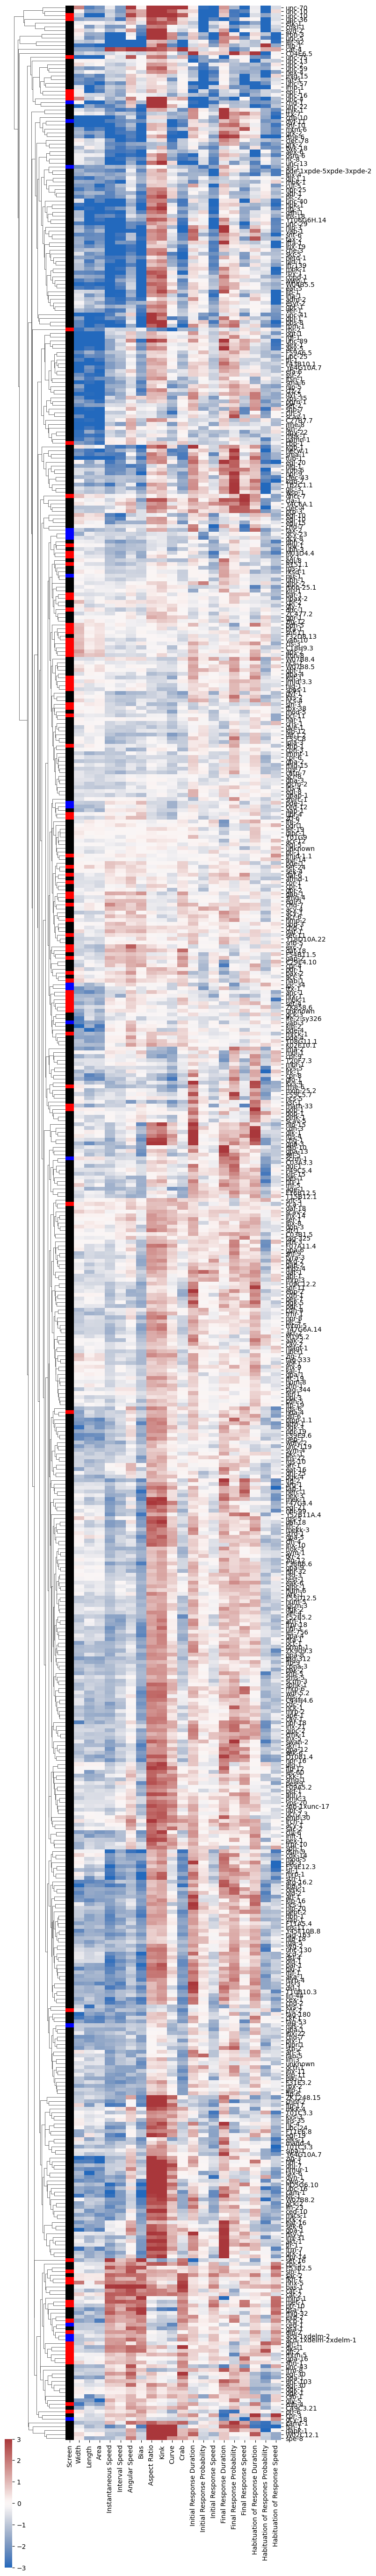

In [10]:
sns.clustermap(
    data_na,
    figsize=(8, 55),
    dendrogram_ratio=(0.2,0),
    cmap=sns.color_palette("vlag", as_cmap=True),
    vmax=3,
    vmin=-3,
    cbar_pos=(0, 0, 0.02, 0.05),
    row_colors=row_colors,
    # method = 'ward',
    # metric = 'canberra',
    row_cluster=True,
    col_cluster=False,
    yticklabels=gene_labels,
)

## Set Input (X) and Output (Y, Classification)

In [11]:
# making labels(Gene), X(features) and Y (target)
Y = category
# Y
X = data_na
# X
labels = gene_labels
# labels

X
Y

0      PD_Screen
1      PD_Screen
2      PD_Screen
3      PD_Screen
4      PD_Screen
         ...    
638    PD_Screen
639    PD_Screen
640    PD_Screen
641    PD_Screen
642    PD_Screen
Name: Screen, Length: 643, dtype: object

In [12]:
print(Y.unique())
# Y = Y.replace("ASD_Screen", "Outgroup")
Y = Y.replace("PD_Screen", "Outgroup") #Rerun kernel with this for in for ASD
Y = Y.replace("Glia_Genes_Screen", "Outgroup")
Y = Y.replace("G-Proteins_Screen", "Outgroup")
Y = Y.replace("Neuron_Genes_Screen", "Outgroup")
Y = Y.replace("DOPAMINE", "Outgroup")
print(Y.unique())
list_Y=['ASD_Screen','Outgroup']
print(list_Y)

['PD_Screen' 'DOPAMINE' 'ASD_Screen' 'Glia_Genes_Screen'
 'G-Proteins_Screen' 'Neuron_Genes_Screen']
['Outgroup' 'ASD_Screen']
['ASD_Screen', 'Outgroup']


## Oversample

### You want to make sure you oversample AFTER your train_test_split!! And only oversample the training set!!

In [13]:
from imblearn.over_sampling import SVMSMOTE
from collections import Counter

oversample = SVMSMOTE()
X_Oversampled, Y_Oversampled = oversample.fit_resample(X,Y)
# X_OS, Y_OS = oversample.fit_resample(X,Y)

counter = Counter(Y_Oversampled)
counter_og = Counter(Y)

print("Oversampled: ", counter)
print("Original: ", counter_og)

Oversampled:  Counter({'Outgroup': 566, 'ASD_Screen': 566})
Original:  Counter({'Outgroup': 566, 'ASD_Screen': 77})


## Random Forrest Classifier

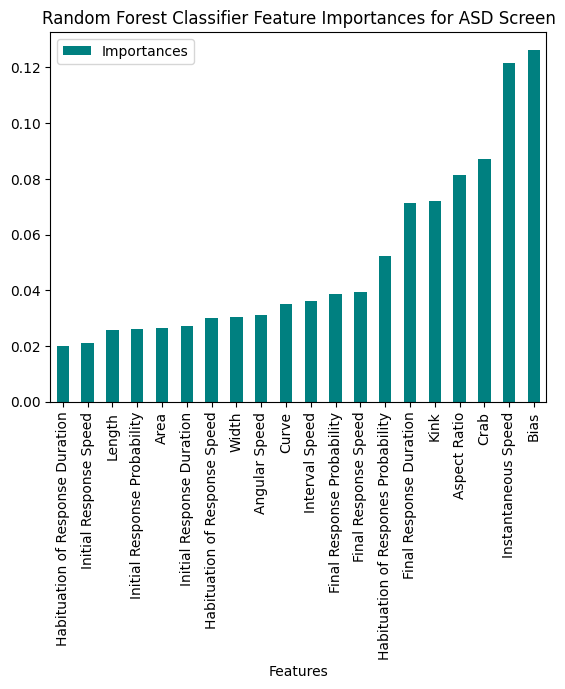

In [14]:
from sklearn.ensemble import RandomForestClassifier

# create random forest model with hyperparameters (keeping default to start)
model = RandomForestClassifier()
model.fit(X_Oversampled, Y_Oversampled)

# get the importance of the resulting features
importances = model.feature_importances_

# create a dataframe for visualization
final_df = pd.DataFrame({"Features": X.columns, "Importances":importances})
final_df.set_index('Importances')
# print(final_df)

# sort in ascending order to better visualzation
final_df = final_df.sort_values('Importances')

# plot the feature importance in bars
final_df.plot.bar(x = 'Features', y='Importances',color = 'teal', title = 'Random Forest Classifier Feature Importances for ASD Screen')
plt.savefig('/Users/Joseph/Desktop/ASD_RandomForestFeatureImportances.png', bbox_inches='tight')


## Information Gain

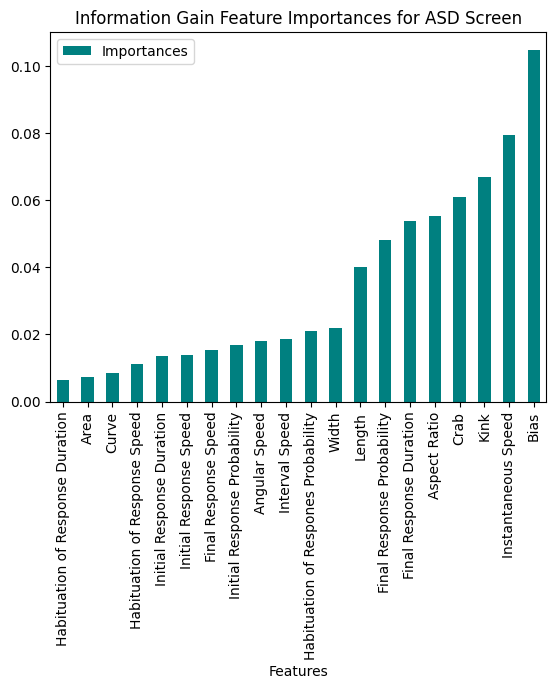

In [15]:
from sklearn.feature_selection import mutual_info_classif
import matplotlib.pyplot as plt
%matplotlib inline

importances = mutual_info_classif(X,Y)
# create a dataframe for visualization
final_df = pd.DataFrame({"Features": X.columns, "Importances":importances})
final_df.set_index('Importances')
# print(final_df)
# sort in ascending order to better visualzation
final_df = final_df.sort_values('Importances')
# plot the feature importance in bars
final_df.plot.bar(x = 'Features', y='Importances',color = 'teal', title = 'Information Gain Feature Importances for ASD Screen')
plt.savefig('/Users/Joseph/Desktop/ASD_InfoGainFeatureImportances.png', bbox_inches='tight')

## Fisher Score

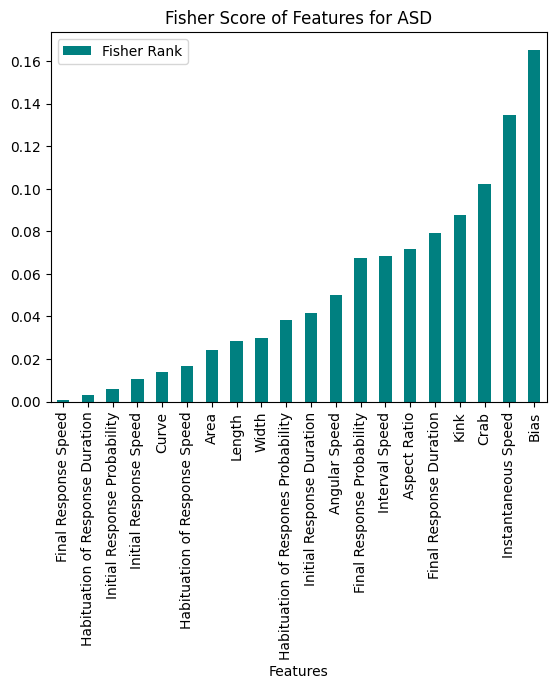

In [16]:
from skfeature.function.similarity_based import fisher_score
%matplotlib inline

ranks = fisher_score.fisher_score(X.to_numpy(),Y.to_numpy())

# create a dataframe for visualization
final_df = pd.DataFrame({"Features": X.columns, "Fisher Rank":ranks})
final_df.set_index('Fisher Rank')
# print(final_df)
# sort in ascending order to better visualzation
final_df = final_df.sort_values('Fisher Rank')
# plot the feature importance in bars
final_df.plot(kind='bar',x = 'Features', y='Fisher Rank',color = 'teal', title = "Fisher Score of Features for ASD")
plt.savefig('/Users/Joseph/Desktop/ASD_FisherScoreFeatureImportances.png', bbox_inches='tight')

## Univariate (ANOVA) Modeling

### k = 5~7 yields best results

In [17]:
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler

# # Generating a sample dataset
# X, y = make_classification(n_samples=100, n_features=20, n_informative=10, n_classes=2, random_state=42)

# Splitting the dataset into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
oversample = SVMSMOTE()
X_train_OS, Y_train_OS = oversample.fit_resample(X_train,Y_train)

# Standardizing the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Applying ANOVA-based feature selection
k_best = 8  # Choose the number of top features you want to select
selector = SelectKBest(f_classif, k=k_best)
X_train_selected = selector.fit_transform(X_train, Y_train)
X_test_selected = selector.transform(X_test)

# Displaying selected feature indices
selected_indices = np.where(selector.get_support())[0]
selected_features = X.columns[selected_indices]
print("Selected feature indices:", selected_indices)
print("Selected features:", selected_features)
# print(X_train_selected)
# Optionally, you can train a model on the selected features
# For example, using a simple classifier like Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

model = RandomForestClassifier()
model.fit(X_train_selected, Y_train)
# Accuracy 0.8217054263565892

# model = LogisticRegression(random_state=42)  
# model.fit(X_train_selected, Y_train)
# Accuracy 0.7286821705426356

# Predicting on the test set
y_pred = model.predict(X_test_selected)

# Evaluating the model
accuracy = accuracy_score(Y_test, y_pred)
print("Accuracy on the test set:", accuracy)


Selected feature indices: [ 3  4  6  7  8 10 14 15]
Selected features: Index(['Instantaneous Speed', 'Interval Speed', 'Bias', 'Aspect Ratio', 'Kink',
       'Crab', 'Final Response Duration', 'Final Response Probability'],
      dtype='object')
Accuracy on the test set: 0.8837209302325582


## Forward Feature Selection

In [18]:
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler

# # Generating a sample dataset
# X, y = make_classification(n_samples=100, n_features=20, n_informative=10, n_classes=2, random_state=42)

# Splitting the dataset into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
oversample = SVMSMOTE()
X_train_OS, Y_train_OS = oversample.fit_resample(X_train,Y_train)


# Standardizing the features
scaler = StandardScaler()
X_Train = scaler.fit_transform(X_train_OS)
X_Test = scaler.transform(X_test)

# Applying ANOVA-based feature selection
k_best = 7  # Choose the number of top features you want to select
selector = SelectKBest(f_classif, k=k_best)
X_train_selected = selector.fit_transform(X_Train, Y_train_OS)
X_test_selected = selector.transform(X_test)

# Displaying selected feature indices
selected_indices = np.where(selector.get_support())[0]
selected_features = X.columns[selected_indices]
print("Selected feature indices:", selected_indices)
print("Selected features:", selected_features)
# print(X_train_selected)
# Optionally, you can train a model on the selected features
# For example, using a simple classifier like Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# model = RandomForestClassifier()
# model.fit(X_train_selected, Y_train_OS)
# Accuracy 0.8217054263565892

model = LogisticRegression(random_state=42)  
model.fit(X_train_selected, Y_train_OS)
# Accuracy 0.7286821705426356

# Predicting on the test set
y_pred = model.predict(X_test_selected)

# Evaluating the model
accuracy = accuracy_score(Y_test, y_pred)
print("Accuracy on the test set:", accuracy)


Selected feature indices: [ 3  6  7  8 10 14 18]
Selected features: Index(['Instantaneous Speed', 'Bias', 'Aspect Ratio', 'Kink', 'Crab',
       'Final Response Duration', 'Habituation of Respones Probability'],
      dtype='object')
Accuracy on the test set: 0.8604651162790697


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectKBest was fitted without feature names
  warnings.warn(


## More involved algorithms (still forward feature selection, but this time using Random Forest)

In [43]:
import random

fruits = ["apple","pineapple","orange"]

while len(fruits) > 0:
    print("original list: ", fruits)
    rand = random.choice(fruits)
    print("random choice: ", rand)
    fruits.remove(rand)
    print("new list: ", fruits)
    print("starting again...")


# for fruit in fruits:
#     print("original list: ", fruits)
#     rand = random.choice(fruits)
#     print("random choice: ", rand)
#     fruits.remove(rand)
#     print("new list: ", fruits)
#     print("starting again...")

print(fruits)


original list:  ['apple', 'pineapple', 'orange']
random choice:  pineapple
new list:  ['apple', 'orange']
starting again...
original list:  ['apple', 'orange']
random choice:  apple
new list:  ['orange']
starting again...
original list:  ['orange']
random choice:  orange
new list:  []
starting again...
[]


In [50]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
import random

def forward_feature_selection(X_train, X_test, y_train, y_test, model, max_features=10):
    """
    Forward Feature Selection
    """
    selected_features = []
    best_score = 0

    while len(selected_features) < max_features if max_features else X_train.shape[1]:
        remaining_features = [feature for feature in range(X_train.shape[1]) if feature not in selected_features]
        candidate_scores = []

        while len(remaining_features) > 0:
            rand_feature = random.choice(remaining_features)
            remaining_features.remove(rand_feature)
            current_features = selected_features + [rand_feature]
            model.fit(X_train[:, current_features], y_train)
            y_pred = model.predict(X_test[:, current_features])
            acc_score = accuracy_score(y_test, y_pred)
            F1 = f1_score(y_test,y_pred, pos_label='ASD_Screen')
            candidate_scores.append((rand_feature, F1))
            

        # for feature in remaining_features:
        #     current_features = selected_features + [feature]
        #     model.fit(X_train[:, current_features], y_train)
        #     y_pred = model.predict(X_test[:, current_features])
        #     acc_score = accuracy_score(y_test, y_pred)
        #     F1 = f1_score(y_test,y_pred, pos_label='ASD_Screen')
        #     candidate_scores.append((feature, F1))

        # Select the feature that gives the best score
        best_candidate = max(candidate_scores, key=lambda x: x[1])

        # Check if adding the feature improves the model
        if best_candidate[1] > best_score:
            selected_features.append(best_candidate[0])
            best_score = best_candidate[1]
        else:
            break

    return selected_features

In [51]:
# # Splitting the dataset into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
oversample = SVMSMOTE()
X_train_OS, Y_train_OS = oversample.fit_resample(X_train,Y_train)

# Standardizing the features
scaler = StandardScaler()
X_Train = scaler.fit_transform(X_train_OS)
X_Test = scaler.transform(X_test)

# Using a simple classifier like RandomForestClassifier
model = RandomForestClassifier()

# Performing forward feature selection
selected_features = forward_feature_selection(X_Train, X_Test, Y_train_OS, Y_test, model)

print("Selected feature indices:", selected_features)
print("Selected features:", X.columns[selected_features])

# Optionally, you can train a model on the selected features
model.fit(X_Train[:, selected_features], Y_train_OS)
y_pred = model.predict(X_Test[:, selected_features])
y_prob = np.max(model.predict_proba(X_Test[:, selected_features]), axis=1)

# Evaluating the model
accuracy = accuracy_score(Y_test, y_pred)
print("Accuracy on the test set:", accuracy)
F1 = f1_score(Y_test,y_pred, pos_label='ASD_Screen')
print("F1-Measure on the test set:", F1)

# pred_conf = pd.DataFrame(np.array([y_pred, y_prob]), columns = ["Prediction", "Confidence"])
d = {'prediction': y_pred, 'confidence': y_prob, "class":Y_test}
df = pd.DataFrame(data=d)
print(df)
# print(pred_conf)

Selected feature indices: [6, 11, 17, 16, 0, 15, 19]
Selected features: Index(['Bias', 'Initial Response Duration', 'Habituation of Response Duration',
       'Final Response Speed', 'Width', 'Final Response Probability',
       'Habituation of Response Speed'],
      dtype='object')
Accuracy on the test set: 0.875968992248062
F1-Measure on the test set: 0.6190476190476191
     prediction  confidence       class
630    Outgroup        0.75    Outgroup
367    Outgroup        0.70    Outgroup
485    Outgroup        0.99    Outgroup
290    Outgroup        0.60    Outgroup
72     Outgroup        0.80    Outgroup
..          ...         ...         ...
346    Outgroup        1.00    Outgroup
641    Outgroup        0.72    Outgroup
215    Outgroup        0.78    Outgroup
606    Outgroup        0.96    Outgroup
135  ASD_Screen        0.90  ASD_Screen

[129 rows x 3 columns]


In [52]:
import multiprocessing
multiprocessing.cpu_count()

8

In [53]:
MonteCarlo = pd.DataFrame(columns=['Feature Indices','Feature Names','Accuracy', 'F1'])
MonteCarlo['Feature Indices'] = MonteCarlo['Feature Indices'].astype('object')
MonteCarlo['Feature Names'] = MonteCarlo['Feature Names'].astype('object')

In [56]:
def run_sim():

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
    oversample = SVMSMOTE()
    X_train_OS, Y_train_OS = oversample.fit_resample(X_train,Y_train)  
# Standardizing the features
    scaler = StandardScaler()
    X_Train = scaler.fit_transform(X_train_OS)
    X_Test = scaler.transform(X_test)
# Using a simple classifier like RandomForestClassifier
    model = RandomForestClassifier()
# Performing forward feature selection
    selected_features = forward_feature_selection(X_Train, X_Test, Y_train_OS, Y_test, model)
    selected_feature_names = X.columns[selected_features]
# print("Selected feature indices:", selected_features)
# print("Selected features:", X.columns[selected_features])

# Optionally, you can train a model on the selected features
    model.fit(X_Train[:, selected_features], Y_train_OS)
    y_pred = model.predict(X_Test[:, selected_features])
    y_prob = np.max(model.predict_proba(X_Test[:, selected_features]), axis=1)
# Evaluating the model
    accuracy = accuracy_score(Y_test, y_pred)
    F1 = f1_score(Y_test,y_pred, pos_label='ASD_Screen')
    new_row = {'Feature Indices': set(selected_features),'Feature Names': set(selected_feature_names),'Accuracy': accuracy, 'F1': F1}
# print(new_row)
# print("Accuracy on the test set:", accuracy)
    MonteCarlo.loc[i] = new_row

In [59]:
MonteCarlo = pd.DataFrame(columns=['Feature Indices','Feature Names','Accuracy', 'F1'])
MonteCarlo['Feature Indices'] = MonteCarlo['Feature Indices'].astype('object')
MonteCarlo['Feature Names'] = MonteCarlo['Feature Names'].astype('object')

pool = multiprocessing.Pool(processes=multiprocessing.cpu_count())
for i in tqdm(range(5000)):
   pool.apply_async(run_sim(), callback = "")
pool.close()
pool.join()

MonteCarlo

100%|██████████████████████████████████████| 5000/5000 [19:41:50<00:00, 14.18s/it]


Feature Indices  \
0      {1, 7, 10, 11, 14, 15}   
1              {0, 16, 11, 6}   
2                     {11, 6}   
3                 {17, 11, 6}   
4                  {1, 6, 17}   
...                       ...   
4995  {8, 10, 11, 16, 18, 19}   
4996              {1, 14, 15}   
4997   {0, 6, 11, 15, 16, 17}   
4998              {17, 3, 12}   
4999               {8, 3, 14}   

                                          Feature Names  Accuracy        F1  
0     {Crab, Final Response Probability, Final Respo...  0.899225  0.682927  
1     {Bias, Final Response Speed, Initial Response ...  0.852713  0.595745  
2                     {Bias, Initial Response Duration}  0.775194  0.524590  
3     {Bias, Initial Response Duration, Habituation ...  0.860465  0.550000  
4      {Length, Bias, Habituation of Response Duration}  0.806202  0.528302  
...                                                 ...       ...       ...  
4995  {Crab, Kink, Habituation of Response Speed, Ha...  0.852713  0.558140  
4996  {Length, Final Response Probability, Final Res...  0.829457  0.500000  
4997  {Final Response Probability, Habituation of Re...  0.875969  0.636364  
4998  {Instantaneous Speed, Habituation of Response ...  0.798450  0.458333  
4999  {Instantaneous Speed, Final Response Duration,...  0.806202  0.444444  

[5000 rows x 4 columns]

In [60]:
MonteCarlo.to_csv('/Users/Joseph/Desktop/ASD_MonteCarloFeatureSelection_new5000.csv')

In [61]:
print(MonteCarlo.sort_values(by=['F1']))

                          Feature Indices  \
1647                        {0, 1, 6, 17}   
3764                {0, 1, 6, 10, 11, 17}   
3704                              {10, 6}   
666                               {6, 14}   
3337                              {10, 3}   
...                                   ...   
1365  {0, 1, 6, 7, 9, 10, 14, 15, 16, 19}   
4528   {2, 7, 10, 11, 13, 14, 16, 17, 18}   
2837            {2, 6, 7, 10, 11, 14, 19}   
1575    {0, 1, 7, 10, 11, 14, 15, 16, 17}   
1653     {2, 5, 6, 7, 10, 14, 15, 16, 18}   

                                          Feature Names  Accuracy        F1  
1647  {Length, Bias, Width, Habituation of Response ...  0.806202  0.358974  
3764  {Crab, Habituation of Response Duration, Lengt...  0.782946  0.363636  
3704                                       {Crab, Bias}  0.705426  0.366667  
666                     {Bias, Final Response Duration}  0.759690  0.367347  
3337                        {Crab, Instantaneous Speed}  0.713178  0.

## For selected features from feature selection processes above:

In [347]:
# selected_features = [6, 12, 14, 19, 0, 11, 13]
selected_features = [2, 6, 7, 10, 11, 14, 19]

print("Selected feature indices:", selected_features)
print("Selected features:", X.columns[selected_features])

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
oversample = SVMSMOTE()
X_train_OS, Y_train_OS = oversample.fit_resample(X_train,Y_train)  
# Standardizing the features
scaler = StandardScaler()
X_Train = scaler.fit_transform(X_train_OS)
X_Test = scaler.transform(X_test)

# Using a simple classifier like RandomForestClassifier
model = RandomForestClassifier()

# Optionally, you can train a model on the selected features
model.fit(X_Train[:, selected_features], Y_train_OS)
y_pred = model.predict(X_Test[:, selected_features])
y_prob = np.max(model.predict_proba(X_Test[:, selected_features]), axis=1) 

# Evaluating the model
accuracy = accuracy_score(Y_test, y_pred)
print("Accuracy on the test set:", accuracy)
F1 = f1_score(Y_test,y_pred, pos_label='ASD_Screen')
print("F1-Measure on the test set:", F1)
# pred_conf = pd.DataFrame(np.array([y_pred, y_prob]), columns = ["Prediction", "Confidence"])
d = {'prediction': y_pred, 'confidence': y_prob, "class":Y_test}
df = pd.DataFrame(data=d)
print(df)

Selected feature indices: [2, 6, 7, 10, 11, 14, 19]
Selected features: Index(['Area', 'Bias', 'Aspect Ratio', 'Crab', 'Initial Response Duration',
       'Final Response Duration', 'Habituation of Response Speed'],
      dtype='object')
Accuracy on the test set: 0.875968992248062
F1-Measure on the test set: 0.6190476190476191
     prediction  confidence       class
630    Outgroup        0.60    Outgroup
367    Outgroup        0.58    Outgroup
485    Outgroup        0.99    Outgroup
290    Outgroup        0.82    Outgroup
72     Outgroup        0.69    Outgroup
..          ...         ...         ...
346    Outgroup        0.99    Outgroup
641    Outgroup        0.61    Outgroup
215    Outgroup        0.77    Outgroup
606    Outgroup        0.98    Outgroup
135  ASD_Screen        0.60  ASD_Screen

[129 rows x 3 columns]


### Saving the model:

In [46]:
from joblib import dump, load
dump(model, '/Users/Joseph/Desktop/NRSC510B/ASD_Screen_Model.joblib') 

['/Users/Joseph/Desktop/NRSC510B/ASD_Screen_Model.joblib']

In [85]:
for col in X.columns:
    print(col)

Width
Length
Area
Instantaneous Speed
Interval Speed
Angular Speed
Bias
Aspect Ratio
Kink
Curve
Crab
Initial Response Duration
Initial Response Probability
Initial Response Speed
Final Response Duration
Final Response Probability
Final Response Speed
Habituation of Response Duration
Habituation of Respones Probability
Habituation of Response Speed


## ROC Curve

Text(0, 0.5, 'recall')

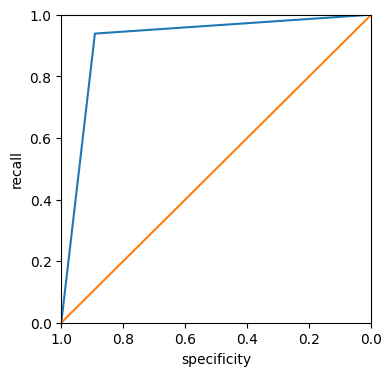

In [65]:
from sklearn.metrics import roc_curve as roc_curve

def binaryize(inlist):
    for i in range(len(inlist)):
        if inlist[i] == 'Outgroup':
            inlist[i] = 0
        if inlist[i] == 'ASD_Screen':
            inlist[i] = 1
    return inlist

y_test_binary = binaryize(y_test.tolist())
y_pred_binary = binaryize(y_pred)

fpr, tpr, thresholds = roc_curve(y_test_binary, y_pred_binary, pos_label=1)
roc_df = pd.DataFrame({'recall': tpr, 'specificity': 1-fpr})

ax = roc_df.plot(x='specificity', y='recall', figsize=(4,4), legend=False)
ax.set_ylim(0,1)
ax.set_xlim(1,0)
ax.plot((1,0),(0,1))
ax.set_xlabel('specificity')
ax.set_ylabel('recall')

In [66]:
from sklearn.metrics import roc_auc_score 

print(np.sum(roc_df.recall[:-1]*np.diff(1-roc_df.specificity)))
print(roc_auc_score([1 if yi == 1 else 0 for yi in y_test_binary],
                    y_pred_binary))

0.8368928966935613
0.915124189210568


## Backward Feature Elimination

In [44]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

def backward_feature_elimination(X_train, X_test, y_train, y_test, model):
    """
    Backward Feature Elimination
    """
    sselected_features = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
# 10 features: 0.8449612403100775
# 7 features: 0.8449612403100775 <--- 7 features sweet spot
# 6 features: 0.8294573643410853
    while len(sselected_features) > 6:
        current_score = 0
        worst_feature = None

        for feature in sselected_features:
            remaining_features = [f for f in sselected_features if f != feature]
            model.fit(X_train[:, remaining_features], y_train)
            y_pred = model.predict(X_test[:, remaining_features])
            score = accuracy_score(y_test, y_pred)

            if score > current_score:
                current_score = score
                worst_feature = feature

        if worst_feature is not None:
            sselected_features.remove(worst_feature)
        else:
            break

    return sselected_features

# Generating a sample dataset
# X, y = make_classification(n_samples=100, n_features=20, n_informative=10, n_classes=2, random_state=42)

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, random_state=42)

# Standardizing the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# print(X_train.shape)
# Using a simple classifier like RandomForestClassifier
model = RandomForestClassifier(random_state=42)

# Performing Backward Feature Elimination (BFE)
sselected_features = backward_feature_elimination(X_train, X_test, y_train, y_test, model)

print("Selected feature indices:", sselected_features)
print("Selected features:", X.columns[sselected_features])

# Optionally, you can train a model on the selected features
model.fit(X_train[:, sselected_features], y_train)
y_pred = model.predict(X_test[:, sselected_features])

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on the test set:", accuracy)


Selected feature indices: [3, 8, 14, 15, 17, 18]
Selected features: Index(['Instantaneous Speed', 'Kink', 'Final Response Duration',
       'Final Response Probability', 'Habituation of Response Duration',
       'Habituation of Respones Probability'],
      dtype='object')
Accuracy on the test set: 0.8294573643410853


## Recursive Feature Elimination

In [45]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score

# Generating a sample dataset
# X, y = make_classification(n_samples=100, n_features=20, n_informative=10, n_classes=2, random_state=42)

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Standardizing the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Using a simple classifier like RandomForestClassifier
model = RandomForestClassifier(random_state=42)

# Performing Recursive Feature Elimination (RFE)
num_features_to_select = 5  # Choose the number of features to select
rfe = RFE(estimator=model, n_features_to_select=num_features_to_select)
X_train_rfe = rfe.fit_transform(X_train, y_train)
X_test_rfe = rfe.transform(X_test)

# Displaying selected feature indices
selected_features = [i for i in range(len(rfe.support_)) if rfe.support_[i]]
print("Selected feature indices:", selected_features)
print("Selected feature indices:", X.columns[selected_features])

# Optionally, you can train a model on the selected features
model.fit(X_train_rfe, y_train)
y_pred = model.predict(X_test_rfe)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on the test set:", accuracy)


Selected feature indices: [6, 7, 8, 14, 18]
Selected feature indices: Index(['Bias', 'Aspect Ratio', 'Kink', 'Final Response Duration',
       'Habituation of Respones Probability'],
      dtype='object')
Accuracy on the test set: 0.8062015503875969


# Now Performing Clustering Of ASD_Screen Only for Profile Sub-types

In [388]:
# PD_Screen_other = tstat_gene[tstat_gene.Screen != "ASD_Screen"].reset_index().drop(columns=['index'])
# PD_Screen_other

In [387]:
# print(PD_Screen_other[PD_Screen_other.Gene == 'N2'])
# PD_Screen_other = PD_Screen_other.drop([5,92,111,187,606])
# print(PD_Screen_other[PD_Screen_other.Gene == 'N2']) 

In [386]:
# PD_Screen_other1 = PD_Screen_other[['Gene','Area', 'Bias', 'Aspect Ratio', 'Crab', 'Initial Response Duration',
#        'Final Response Duration', 'Habituation of Response Speed']]

# PD_Screen_other1 = PD_Screen_other1.dropna()
# PD_Screen_other1

In [389]:
# PD_Screen_other_Genes=PD_Screen_other1.pop("Gene")
# PD_Screen_other1

In [390]:
# PD_Screen_other_Genes

In [391]:
# print(tstat_gene.shape)
# print(tstat_gene.columns)
# print(tstat_gene.Screen.unique())
# print(tstat_gene.Gene[tstat_gene.Screen == "PD_Screen"])
PD_Screen = tstat_gene[tstat_gene.Screen == "ASD_Screen"].reset_index().drop(columns=['index'])
PD_Screen

Gene     Width    Length      Area  Instantaneous Speed  \
0   C18H9.3  0.940727  0.194177  0.435323            -0.616387   
1   M03D4.4 -0.150020 -0.791369 -0.629753            -1.329001   
2        N2  0.000000  0.000000  0.000000             0.000000   
3    R151.1 -0.095614 -0.545433 -0.581830            -1.093169   
4   ZK858.6 -0.860502 -0.540469 -0.659422             0.136818   
..      ...       ...       ...       ...                  ...   
73    unc-4  1.697597 -0.914467 -0.283482            -1.475994   
74   unc-75 -3.422406 -3.796192 -4.700223             0.182448   
75  unknown -1.623364 -0.740658 -1.523966             0.285889   
76   vab-10  0.890670  0.360246  0.478454            -0.690072   
77    ztf-6 -0.650144 -0.842306 -0.589301             0.576706   

    Interval Speed  Angular Speed      Bias  Aspect Ratio      Kink  ...  \
0        -0.933432      -0.512625 -0.906314     -0.115086 -0.113857  ...   
1        -1.685624      -0.787482 -1.528013     -0.026771  0.213912  ...   
2         0.000000       0.000000  0.000000      0.000000  0.000000  ...   
3        -1.399185      -1.083517 -0.672784      0.274941  0.713870  ...   
4        -0.072119       0.610141  0.053918      0.233398 -0.079960  ...   
..             ...            ...       ...           ...       ...  ...   
73       -0.852815       1.872147 -0.168112      3.886903  3.200391  ...   
74       -0.504601       2.547544 -0.038110      1.955491  2.086112  ...   
75        0.415973       0.408889  0.075470     -0.300840 -0.139715  ...   
76       -0.493535      -0.959294 -0.610486     -0.026438 -0.028862  ...   
77        0.250906       0.957243  0.977324     -0.564990 -0.816425  ...   

    Final Response Duration  Final Response Probability  Final Response Speed  \
0                  0.374578                    0.247706              0.206590   
1                 -0.439289                    0.987110             -0.532434   
2                  0.000000                    0.000000              0.000000   
3                  1.459391                    0.179927             -1.214247   
4                 -0.551079                   -0.444824              0.173807   
..                      ...                         ...                   ...   
73                -2.117566                   -4.073790             -0.000899   
74                -3.108427                    0.070456             -0.098484   
75                -0.036111                   -0.354254              0.700393   
76                 0.288109                   -0.429302              0.273549   
77                 0.285350                   -0.271564             -0.112921   

    Habituation of Response Duration  Habituation of Respones Probability  \
0                           0.431994                            -1.000768   
1                           0.692922                            -1.583784   
2                           0.000000                             0.000000   
3                          -0.915533                            -0.135349   
4                          -0.276494                             0.901949   
..                               ...                                  ...   
73                         -2.373928                            -2.977531   
74                         -2.032740                            -2.408634   
75                         -0.063418                             0.279533   
76                         -0.028272                             0.562792   
77                         -0.077756                            -1.002319   

    Habituation of Response Speed  Spontaneous Recovery of Response Duration  \
0                       -0.852143                                  -1.318852   
1                       -2.570717                                   0.380095   
2                        0.000000                                   0.000000   
3                       -1.062773                                  -0.526730   
4  

In [392]:
print(PD_Screen[PD_Screen.Gene == 'N2'])
PD_Screen = PD_Screen.drop([2])
print(PD_Screen[PD_Screen.Gene == 'N2']) 

  Gene  Width  Length  Area  Instantaneous Speed  Interval Speed  \
2   N2    0.0     0.0   0.0                  0.0             0.0   

   Angular Speed  Bias  Aspect Ratio  Kink  ...  Final Response Duration  \
2            0.0   0.0           0.0   0.0  ...                      0.0   

   Final Response Probability  Final Response Speed  \
2                         0.0                   0.0   

   Habituation of Response Duration  Habituation of Respones Probability  \
2                               0.0                                  0.0   

   Habituation of Response Speed  Spontaneous Recovery of Response Duration  \
2                            0.0                                        0.0   

   Spontaneous Recovery of Response Probability  \
2                                           0.0   

   Spontaneous Recovery of Response Speed      Screen  
2                                     0.0  ASD_Screen  

[1 rows x 25 columns]
Empty DataFrame
Columns: [Gene, Width, Length, Ar

In [393]:
# PD_Screen = PD_Screen.drop(columns=['index'])
PD_Screen

Gene     Width    Length      Area  Instantaneous Speed  \
0   C18H9.3  0.940727  0.194177  0.435323            -0.616387   
1   M03D4.4 -0.150020 -0.791369 -0.629753            -1.329001   
3    R151.1 -0.095614 -0.545433 -0.581830            -1.093169   
4   ZK858.6 -0.860502 -0.540469 -0.659422             0.136818   
5     anc-1 -1.972727 -2.285821 -1.739887            -0.719948   
..      ...       ...       ...       ...                  ...   
73    unc-4  1.697597 -0.914467 -0.283482            -1.475994   
74   unc-75 -3.422406 -3.796192 -4.700223             0.182448   
75  unknown -1.623364 -0.740658 -1.523966             0.285889   
76   vab-10  0.890670  0.360246  0.478454            -0.690072   
77    ztf-6 -0.650144 -0.842306 -0.589301             0.576706   

    Interval Speed  Angular Speed      Bias  Aspect Ratio      Kink  ...  \
0        -0.933432      -0.512625 -0.906314     -0.115086 -0.113857  ...   
1        -1.685624      -0.787482 -1.528013     -0.026771  0.213912  ...   
3        -1.399185      -1.083517 -0.672784      0.274941  0.713870  ...   
4        -0.072119       0.610141  0.053918      0.233398 -0.079960  ...   
5        -0.659971       0.835609 -0.519592      0.825648  0.414245  ...   
..             ...            ...       ...           ...       ...  ...   
73       -0.852815       1.872147 -0.168112      3.886903  3.200391  ...   
74       -0.504601       2.547544 -0.038110      1.955491  2.086112  ...   
75        0.415973       0.408889  0.075470     -0.300840 -0.139715  ...   
76       -0.493535      -0.959294 -0.610486     -0.026438 -0.028862  ...   
77        0.250906       0.957243  0.977324     -0.564990 -0.816425  ...   

    Final Response Duration  Final Response Probability  Final Response Speed  \
0                  0.374578                    0.247706              0.206590   
1                 -0.439289                    0.987110             -0.532434   
3                  1.459391                    0.179927             -1.214247   
4                 -0.551079                   -0.444824              0.173807   
5                 -0.085498                   -0.287196             -0.189907   
..                      ...                         ...                   ...   
73                -2.117566                   -4.073790             -0.000899   
74                -3.108427                    0.070456             -0.098484   
75                -0.036111                   -0.354254              0.700393   
76                 0.288109                   -0.429302              0.273549   
77                 0.285350                   -0.271564             -0.112921   

    Habituation of Response Duration  Habituation of Respones Probability  \
0                           0.431994                            -1.000768   
1                           0.692922                            -1.583784   
3                          -0.915533                            -0.135349   
4                          -0.276494                             0.901949   
5                          -0.506484                            -0.230768   
..                               ...                                  ...   
73                         -2.373928                            -2.977531   
74                         -2.032740                            -2.408634   
75                         -0.063418                             0.279533   
76                         -0.028272                             0.562792   
77                         -0.077756                            -1.002319   

    Habituation of Response Speed  Spontaneous Recovery of Response Duration  \
0                       -0.852143                                  -1.318852   
1                       -2.570717                                   0.380095   
3                       -1.062773                                  -0.526730   
4                       -1.131573                                  -0.088358   
5  

In [394]:
X.columns[selected_features]
selected_features

[2, 6, 7, 10, 11, 14, 19]

In [399]:
# selected_feature_names = PD_Screen.columns[selected_features]
# print(selected_feature_names)
# print(list(selected_feature_names))
# type(list(selected_feature_names))

selected_feature_names=['Area', 'Bias', 'Aspect Ratio', 'Crab', 'Initial Response Duration',
       'Final Response Duration', 'Habituation of Response Speed']
print(list(selected_feature_names))
type(list(selected_feature_names))

['Area', 'Bias', 'Aspect Ratio', 'Crab', 'Initial Response Duration', 'Final Response Duration', 'Habituation of Response Speed']


list

In [396]:
PD_Screen1 = PD_Screen[['Gene','Area', 'Bias', 'Aspect Ratio', 'Crab', 'Initial Response Duration',
       'Final Response Duration', 'Habituation of Response Speed']]

PD_Screen1

Gene      Area      Bias  Aspect Ratio      Crab  \
0   C18H9.3  0.435323 -0.906314     -0.115086 -0.021343   
1   M03D4.4 -0.629753 -1.528013     -0.026771  0.011223   
3    R151.1 -0.581830 -0.672784      0.274941 -0.566572   
4   ZK858.6 -0.659422  0.053918      0.233398  0.098777   
5     anc-1 -1.739887 -0.519592      0.825648 -0.271745   
..      ...       ...       ...           ...       ...   
73    unc-4 -0.283482 -0.168112      3.886903  1.289144   
74   unc-75 -4.700223 -0.038110      1.955491  1.042288   
75  unknown -1.523966  0.075470     -0.300840  0.462820   
76   vab-10  0.478454 -0.610486     -0.026438 -0.762457   
77    ztf-6 -0.589301  0.977324     -0.564990  0.107241   

    Initial Response Duration  Final Response Duration  \
0                    0.700340                 0.374578   
1                    0.379903                -0.439289   
3                    0.377571                 1.459391   
4                   -0.432375                -0.551079   
5                   -0.450722                -0.085498   
..                        ...                      ...   
73                  -3.119062                -2.117566   
74                  -2.689913                -3.108427   
75                  -0.060101                -0.036111   
76                   0.421469                 0.288109   
77                   0.162337                 0.285350   

    Habituation of Response Speed  
0                       -0.852143  
1                       -2.570717  
3                       -1.062773  
4                       -1.131573  
5                       -1.584807  
..                            ...  
73                      -1.144794  
74                       0.043558  
75                      -0.671497  
76                      -0.970456  
77                      -0.782507  

[77 rows x 8 columns]

In [397]:
PD_Screen_Genes=PD_Screen1.pop("Gene")

In [400]:
PD_Screen1

Area      Bias  Aspect Ratio      Crab  Initial Response Duration  \
0   0.435323 -0.906314     -0.115086 -0.021343                   0.700340   
1  -0.629753 -1.528013     -0.026771  0.011223                   0.379903   
3  -0.581830 -0.672784      0.274941 -0.566572                   0.377571   
4  -0.659422  0.053918      0.233398  0.098777                  -0.432375   
5  -1.739887 -0.519592      0.825648 -0.271745                  -0.450722   
..       ...       ...           ...       ...                        ...   
73 -0.283482 -0.168112      3.886903  1.289144                  -3.119062   
74 -4.700223 -0.038110      1.955491  1.042288                  -2.689913   
75 -1.523966  0.075470     -0.300840  0.462820                  -0.060101   
76  0.478454 -0.610486     -0.026438 -0.762457                   0.421469   
77 -0.589301  0.977324     -0.564990  0.107241                   0.162337   

    Final Response Duration  Habituation of Response Speed  
0                  0.374578                      -0.852143  
1                 -0.439289                      -2.570717  
3                  1.459391                      -1.062773  
4                 -0.551079                      -1.131573  
5                 -0.085498                      -1.584807  
..                      ...                            ...  
73                -2.117566                      -1.144794  
74                -3.108427                       0.043558  
75                -0.036111                      -0.671497  
76                 0.288109                      -0.970456  
77                 0.285350                      -0.782507  

[77 rows x 7 columns]

In [401]:
feature_list = ['Area', 'Bias', 'Aspect Ratio', 'Crab', 'Initial Response Duration','Final Response Duration', 'Habituation of Response Speed']

## K Means Clustering

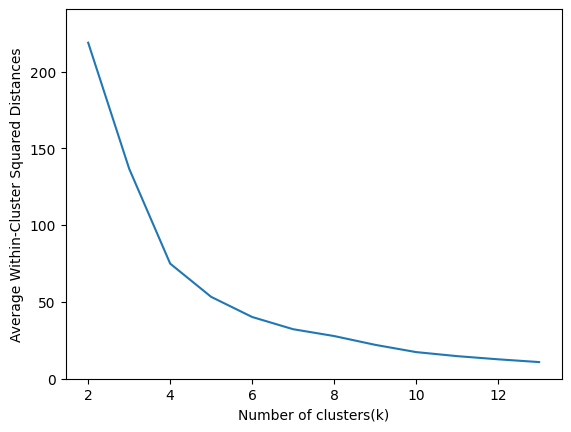

In [402]:
from sklearn.cluster import KMeans

inertia = []
for n_clusters in range(2,14):
    kmeans = KMeans(n_clusters=n_clusters, n_init='auto', random_state=0).fit(PD_Screen1)
    inertia.append(kmeans.inertia_ / n_clusters)

inertias = pd.DataFrame({'n_clusters': range(2,14), 'inertia': inertia})
ax = inertias.plot(x='n_clusters', y='inertia')
plt.xlabel('Number of clusters(k)')
plt.ylabel('Average Within-Cluster Squared Distances')
plt.ylim((0,1.1*inertias.inertia.max()))
ax.legend().set_visible(False)

In [403]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, n_init=10000,random_state=0).fit(PD_Screen1)

In [404]:
kmeans.labels_

array([0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 2, 2, 0, 1, 1, 2, 0, 1, 0, 0, 2,
       2, 1, 2, 2, 2, 2, 2, 2, 0, 2, 1, 0, 1, 2, 0, 0, 0, 0, 1, 2, 1, 2,
       2, 2, 0, 1, 1, 2, 0, 0, 2, 2, 1, 0, 1, 0, 2, 2, 1, 2, 1, 2, 2, 0,
       0, 1, 0, 3, 1, 3, 3, 3, 1, 0, 0], dtype=int32)

In [405]:
kmeans.cluster_centers_

array([[ 0.03546097, -0.0762088 , -0.21443252, -0.14825978,  0.690037  ,
         0.20158876, -0.60651991],
       [-0.99292994, -0.51103565,  0.03144176, -0.01606745, -0.49845148,
        -0.28256565, -1.1503651 ],
       [-0.50271627,  1.33471298,  0.18501349,  1.28652597,  0.05315515,
        -0.27074057,  0.57906287],
       [-2.41223313,  0.34276786,  3.38968536,  1.31355407, -1.49198724,
        -2.61374922, -0.55017214]])

In [406]:
centers = pd.DataFrame(kmeans.cluster_centers_, columns=feature_list)
centers

Area      Bias  Aspect Ratio      Crab  Initial Response Duration  \
0  0.035461 -0.076209     -0.214433 -0.148260                   0.690037   
1 -0.992930 -0.511036      0.031442 -0.016067                  -0.498451   
2 -0.502716  1.334713      0.185013  1.286526                   0.053155   
3 -2.412233  0.342768      3.389685  1.313554                  -1.491987   

   Final Response Duration  Habituation of Response Speed  
0                 0.201589                      -0.606520  
1                -0.282566                      -1.150365  
2                -0.270741                       0.579063  
3                -2.613749                      -0.550172

In [360]:
PD_Screen1['cluster'] = kmeans.labels_
PD_Screen1.head()

/var/folders/31/jpj6mpsx60d9829cymplqfsh0000gn/T/ipykernel_15027/398120266.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PD_Screen1['cluster'] = kmeans.labels_


Area      Bias  Aspect Ratio      Crab  Initial Response Duration  \
0  0.435323 -0.906314     -0.115086 -0.021343                   0.700340   
1 -0.629753 -1.528013     -0.026771  0.011223                   0.379903   
3 -0.581830 -0.672784      0.274941 -0.566572                   0.377571   
4 -0.659422  0.053918      0.233398  0.098777                  -0.432375   
5 -1.739887 -0.519592      0.825648 -0.271745                  -0.450722   

   Final Response Duration  Habituation of Response Speed  cluster  
0                 0.374578                      -0.852143        2  
1                -0.439289                      -2.570717        3  
3                 1.459391                      -1.062773        2  
4                -0.551079                      -1.131573        3  
5                -0.085498                      -1.584807        3

In [407]:
kmeans_counter=Counter(kmeans.labels_)
kmeans_counter

Counter({0: 25, 2: 25, 1: 23, 3: 4})

In [408]:
kmeans.labels_

array([0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 2, 2, 0, 1, 1, 2, 0, 1, 0, 0, 2,
       2, 1, 2, 2, 2, 2, 2, 2, 0, 2, 1, 0, 1, 2, 0, 0, 0, 0, 1, 2, 1, 2,
       2, 2, 0, 1, 1, 2, 0, 0, 2, 2, 1, 0, 1, 0, 2, 2, 1, 2, 1, 2, 2, 0,
       0, 1, 0, 3, 1, 3, 3, 3, 1, 0, 0], dtype=int32)

In [409]:
kmeans.n_features_in_

7

In [410]:
import matplotlib.pyplot as plt

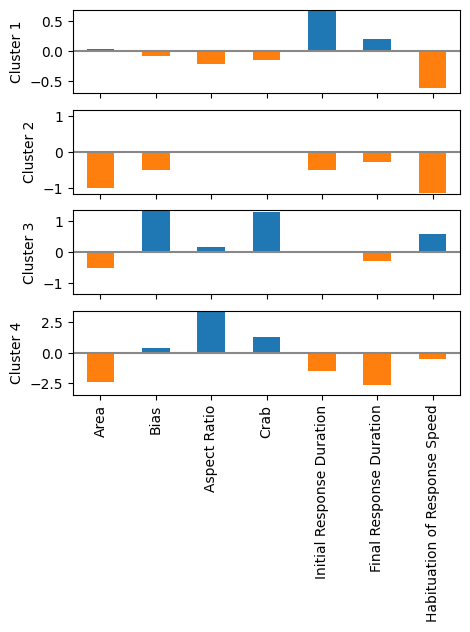

In [411]:
centers = pd.DataFrame(kmeans.cluster_centers_,columns=feature_list)

f,axes = plt.subplots(4,1, figsize=(5,5), sharex=True)
for i,ax in enumerate(axes):
    center = centers.loc[i,:]
    maxPC = 1.01*np.max(np.max(np.abs(center)))
    colors=['C0' if l>0 else 'C1' for l in center]
    ax.axhline(color='#888888')
    center.plot.bar(ax=ax, color=colors)
    ax.set_ylabel(f'Cluster {i+1}')
    ax.set_ylim(-maxPC, maxPC)

In [412]:
centers

Area      Bias  Aspect Ratio      Crab  Initial Response Duration  \
0  0.035461 -0.076209     -0.214433 -0.148260                   0.690037   
1 -0.992930 -0.511036      0.031442 -0.016067                  -0.498451   
2 -0.502716  1.334713      0.185013  1.286526                   0.053155   
3 -2.412233  0.342768      3.389685  1.313554                  -1.491987   

   Final Response Duration  Habituation of Response Speed  
0                 0.201589                      -0.606520  
1                -0.282566                      -1.150365  
2                -0.270741                       0.579063  
3                -2.613749                      -0.550172

### PCA Plot for Clusters

In [310]:
PD_Screen

Gene     Width    Length      Area  Instantaneous Speed  \
0   C18H9.3  0.940727  0.194177  0.435323            -0.616387   
1   M03D4.4 -0.150020 -0.791369 -0.629753            -1.329001   
3    R151.1 -0.095614 -0.545433 -0.581830            -1.093169   
4   ZK858.6 -0.860502 -0.540469 -0.659422             0.136818   
5     anc-1 -1.972727 -2.285821 -1.739887            -0.719948   
..      ...       ...       ...       ...                  ...   
73    unc-4  1.697597 -0.914467 -0.283482            -1.475994   
74   unc-75 -3.422406 -3.796192 -4.700223             0.182448   
75  unknown -1.623364 -0.740658 -1.523966             0.285889   
76   vab-10  0.890670  0.360246  0.478454            -0.690072   
77    ztf-6 -0.650144 -0.842306 -0.589301             0.576706   

    Interval Speed  Angular Speed      Bias  Aspect Ratio      Kink  ...  \
0        -0.933432      -0.512625 -0.906314     -0.115086 -0.113857  ...   
1        -1.685624      -0.787482 -1.528013     -0.026771  0.213912  ...   
3        -1.399185      -1.083517 -0.672784      0.274941  0.713870  ...   
4        -0.072119       0.610141  0.053918      0.233398 -0.079960  ...   
5        -0.659971       0.835609 -0.519592      0.825648  0.414245  ...   
..             ...            ...       ...           ...       ...  ...   
73       -0.852815       1.872147 -0.168112      3.886903  3.200391  ...   
74       -0.504601       2.547544 -0.038110      1.955491  2.086112  ...   
75        0.415973       0.408889  0.075470     -0.300840 -0.139715  ...   
76       -0.493535      -0.959294 -0.610486     -0.026438 -0.028862  ...   
77        0.250906       0.957243  0.977324     -0.564990 -0.816425  ...   

    Final Response Duration  Final Response Probability  Final Response Speed  \
0                  0.374578                    0.247706              0.206590   
1                 -0.439289                    0.987110             -0.532434   
3                  1.459391                    0.179927             -1.214247   
4                 -0.551079                   -0.444824              0.173807   
5                 -0.085498                   -0.287196             -0.189907   
..                      ...                         ...                   ...   
73                -2.117566                   -4.073790             -0.000899   
74                -3.108427                    0.070456             -0.098484   
75                -0.036111                   -0.354254              0.700393   
76                 0.288109                   -0.429302              0.273549   
77                 0.285350                   -0.271564             -0.112921   

    Habituation of Response Duration  Habituation of Respones Probability  \
0                           0.431994                            -1.000768   
1                           0.692922                            -1.583784   
3                          -0.915533                            -0.135349   
4                          -0.276494                             0.901949   
5                          -0.506484                            -0.230768   
..                               ...                                  ...   
73                         -2.373928                            -2.977531   
74                         -2.032740                            -2.408634   
75                         -0.063418                             0.279533   
76                         -0.028272                             0.562792   
77                         -0.077756                            -1.002319   

    Habituation of Response Speed  Spontaneous Recovery of Response Duration  \
0                       -0.852143                                  -1.318852   
1                       -2.570717                                   0.380095   
3                       -1.062773                                  -0.526730   
4                       -1.131573                                  -0.088358   
5  

In [413]:
PD_Screen_test = PD_Screen[['Gene','Area', 'Bias', 'Aspect Ratio', 'Crab', 'Initial Response Duration',
       'Final Response Duration', 'Habituation of Response Speed']]
print(PD_Screen_test.to_string())

        Gene      Area      Bias  Aspect Ratio      Crab  Initial Response Duration  Final Response Duration  Habituation of Response Speed
0    C18H9.3  0.435323 -0.906314     -0.115086 -0.021343                   0.700340                 0.374578                      -0.852143
1    M03D4.4 -0.629753 -1.528013     -0.026771  0.011223                   0.379903                -0.439289                      -2.570717
3     R151.1 -0.581830 -0.672784      0.274941 -0.566572                   0.377571                 1.459391                      -1.062773
4    ZK858.6 -0.659422  0.053918      0.233398  0.098777                  -0.432375                -0.551079                      -1.131573
5      anc-1 -1.739887 -0.519592      0.825648 -0.271745                  -0.450722                -0.085498                      -1.584807
6      aps-2  0.794420 -0.188445     -0.191430 -0.464986                   1.052045                 0.666279                       0.220281
7      bar-1 -0.5260

In [414]:
PD_Screen_PCA = PD_Screen[['Area', 'Bias', 'Aspect Ratio', 'Crab', 'Initial Response Duration', 'Final Response Duration', 'Habituation of Response Speed']]
PD_Screen_PCA = pd.concat([PD_Screen_PCA, centers], ignore_index=True)

Cluster_labels = pd.Series(['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4'])

PD_Screen_PCA_labels = pd.concat([PD_Screen_Genes, Cluster_labels], ignore_index=True)

print(PD_Screen_PCA.to_string())
print(PD_Screen_PCA_labels.to_string())

        Area      Bias  Aspect Ratio      Crab  Initial Response Duration  Final Response Duration  Habituation of Response Speed
0   0.435323 -0.906314     -0.115086 -0.021343                   0.700340                 0.374578                      -0.852143
1  -0.629753 -1.528013     -0.026771  0.011223                   0.379903                -0.439289                      -2.570717
2  -0.581830 -0.672784      0.274941 -0.566572                   0.377571                 1.459391                      -1.062773
3  -0.659422  0.053918      0.233398  0.098777                  -0.432375                -0.551079                      -1.131573
4  -1.739887 -0.519592      0.825648 -0.271745                  -0.450722                -0.085498                      -1.584807
5   0.794420 -0.188445     -0.191430 -0.464986                   1.052045                 0.666279                       0.220281
6  -0.526037 -0.680720      0.224595  0.142113                  -0.260313                -

In [415]:
from sklearn.decomposition import PCA

reduced_data = PCA(n_components=2).fit_transform(PD_Screen_PCA)
# kmeans_PCA = KMeans(n_clusters=4, n_init=10000, random_state=0).fit(reduced_data)

In [380]:
len(kmeans_PCA.labels_)

77

In [381]:
PD_Screen_Genes

0     C18H9.3
1     M03D4.4
3      R151.1
4     ZK858.6
5       anc-1
       ...   
73      unc-4
74     unc-75
75    unknown
76     vab-10
77      ztf-6
Name: Gene, Length: 77, dtype: object

In [416]:
df_PCA = pd.DataFrame({'PCA_x':reduced_data[:,0],'PCA_y':reduced_data[:,1]})
df_PCA_dropped = df_PCA.iloc[:-4]
df_clusters = df_PCA.tail(4).reset_index()
print(df_PCA_dropped.to_string())
print(df_clusters)

       PCA_x     PCA_y
0  -1.758225 -0.159808
1  -1.547768 -2.063928
2  -1.706245 -0.407036
3  -0.137382 -0.888086
4  -0.127815 -1.785191
5  -1.840611  0.985238
6  -0.675060 -1.037661
7  -1.129642 -1.114569
8  -0.820296 -0.050359
9   1.575018 -1.232774
10 -0.275518  0.224822
11  0.301319  0.949032
12 -0.306832  1.972708
13 -1.708913  0.083831
14 -2.515095 -2.634284
15  0.064262  0.099390
16  1.767336  0.573518
17 -1.074078  0.608296
18 -0.500710 -0.988903
19 -1.708245 -0.935197
20 -1.912763 -0.494875
21  0.664311  2.029439
22  2.691116  1.602323
23  1.669122 -2.853905
24  1.130784  0.029905
25  1.677981  2.324352
26  0.895502  1.416263
27  0.499898  1.387538
28 -0.108825  2.371959
29  0.983795  1.377022
30 -0.778221  0.593415
31  1.776248  2.422305
32 -0.907788 -0.995103
33 -0.874815  0.894337
34 -0.948559 -1.808366
35 -0.011747  0.998776
36 -1.368954  0.568209
37 -1.684555  0.544622
38 -1.747898 -0.123603
39 -0.708926  0.270640
40 -0.139870 -1.120474
41  1.702733  2.890725
42  0.32625

In [354]:
# df_PCA_dropped2 = df_PCA_dropped.iloc[:-566]
# df_PCA_others = df_PCA_dropped.tail(566).reset_index()
# print(df_PCA_dropped2)
# print(df_PCA_others)

In [355]:
# df_PCA_others['Gene'] = PD_Screen_other_Genes.reset_index().drop(columns=['index'])
# df_PCA_others

In [316]:
print(PD_Screen_Genes.reset_index().drop(columns=['index']))

       Gene
0   C18H9.3
1   M03D4.4
2    R151.1
3   ZK858.6
4     anc-1
..      ...
72    unc-4
73   unc-75
74  unknown
75   vab-10
76    ztf-6

[77 rows x 1 columns]


In [317]:
# df_PCA_dropped

In [417]:
# df_PCA = pd.DataFrame({'PCA_x':reduced_data[:,0],'PCA_y':reduced_data[:,1]})
df_PCA_dropped['KMeans'] = kmeans.labels_
# df_PCA['KMeans_PCA'] = kmeans_PCA.labels_
df_PCA_dropped['Gene'] = PD_Screen_Genes.reset_index().drop(columns=['index'])
df_PCA_dropped

/var/folders/31/jpj6mpsx60d9829cymplqfsh0000gn/T/ipykernel_15027/350561850.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_PCA_dropped['KMeans'] = kmeans.labels_
/var/folders/31/jpj6mpsx60d9829cymplqfsh0000gn/T/ipykernel_15027/350561850.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_PCA_dropped['Gene'] = PD_Screen_Genes.reset_index().drop(columns=['index'])


PCA_x     PCA_y  KMeans     Gene
0  -1.758225 -0.159808       0  C18H9.3
1  -1.547768 -2.063928       1  M03D4.4
2  -1.706245 -0.407036       0   R151.1
3  -0.137382 -0.888086       1  ZK858.6
4  -0.127815 -1.785191       1    anc-1
..       ...       ...     ...      ...
72  3.328660 -2.988037       3    unc-4
73  4.485692 -3.197220       3   unc-75
74 -0.083242 -0.302902       1  unknown
75 -1.878729 -0.430330       0   vab-10
76 -0.594350  0.486527       0    ztf-6

[77 rows x 4 columns]

In [418]:
df_clusters['Clusters'] = ['Cluster 1','Cluster 2','Cluster 3','Cluster 4']
df_clusters

index     PCA_x     PCA_y   Clusters
0     77 -1.285993  0.214861  Cluster 1
1     78 -0.448953 -1.186846  Cluster 2
2     79  0.960401  1.338832  Cluster 3
3     80  3.848054 -2.382346  Cluster 4

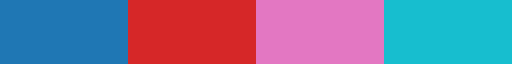

In [225]:
my_palette

In [226]:
sns.color_palette("tab10")

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [227]:
print(sns.color_palette("tab10").as_hex())

['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']


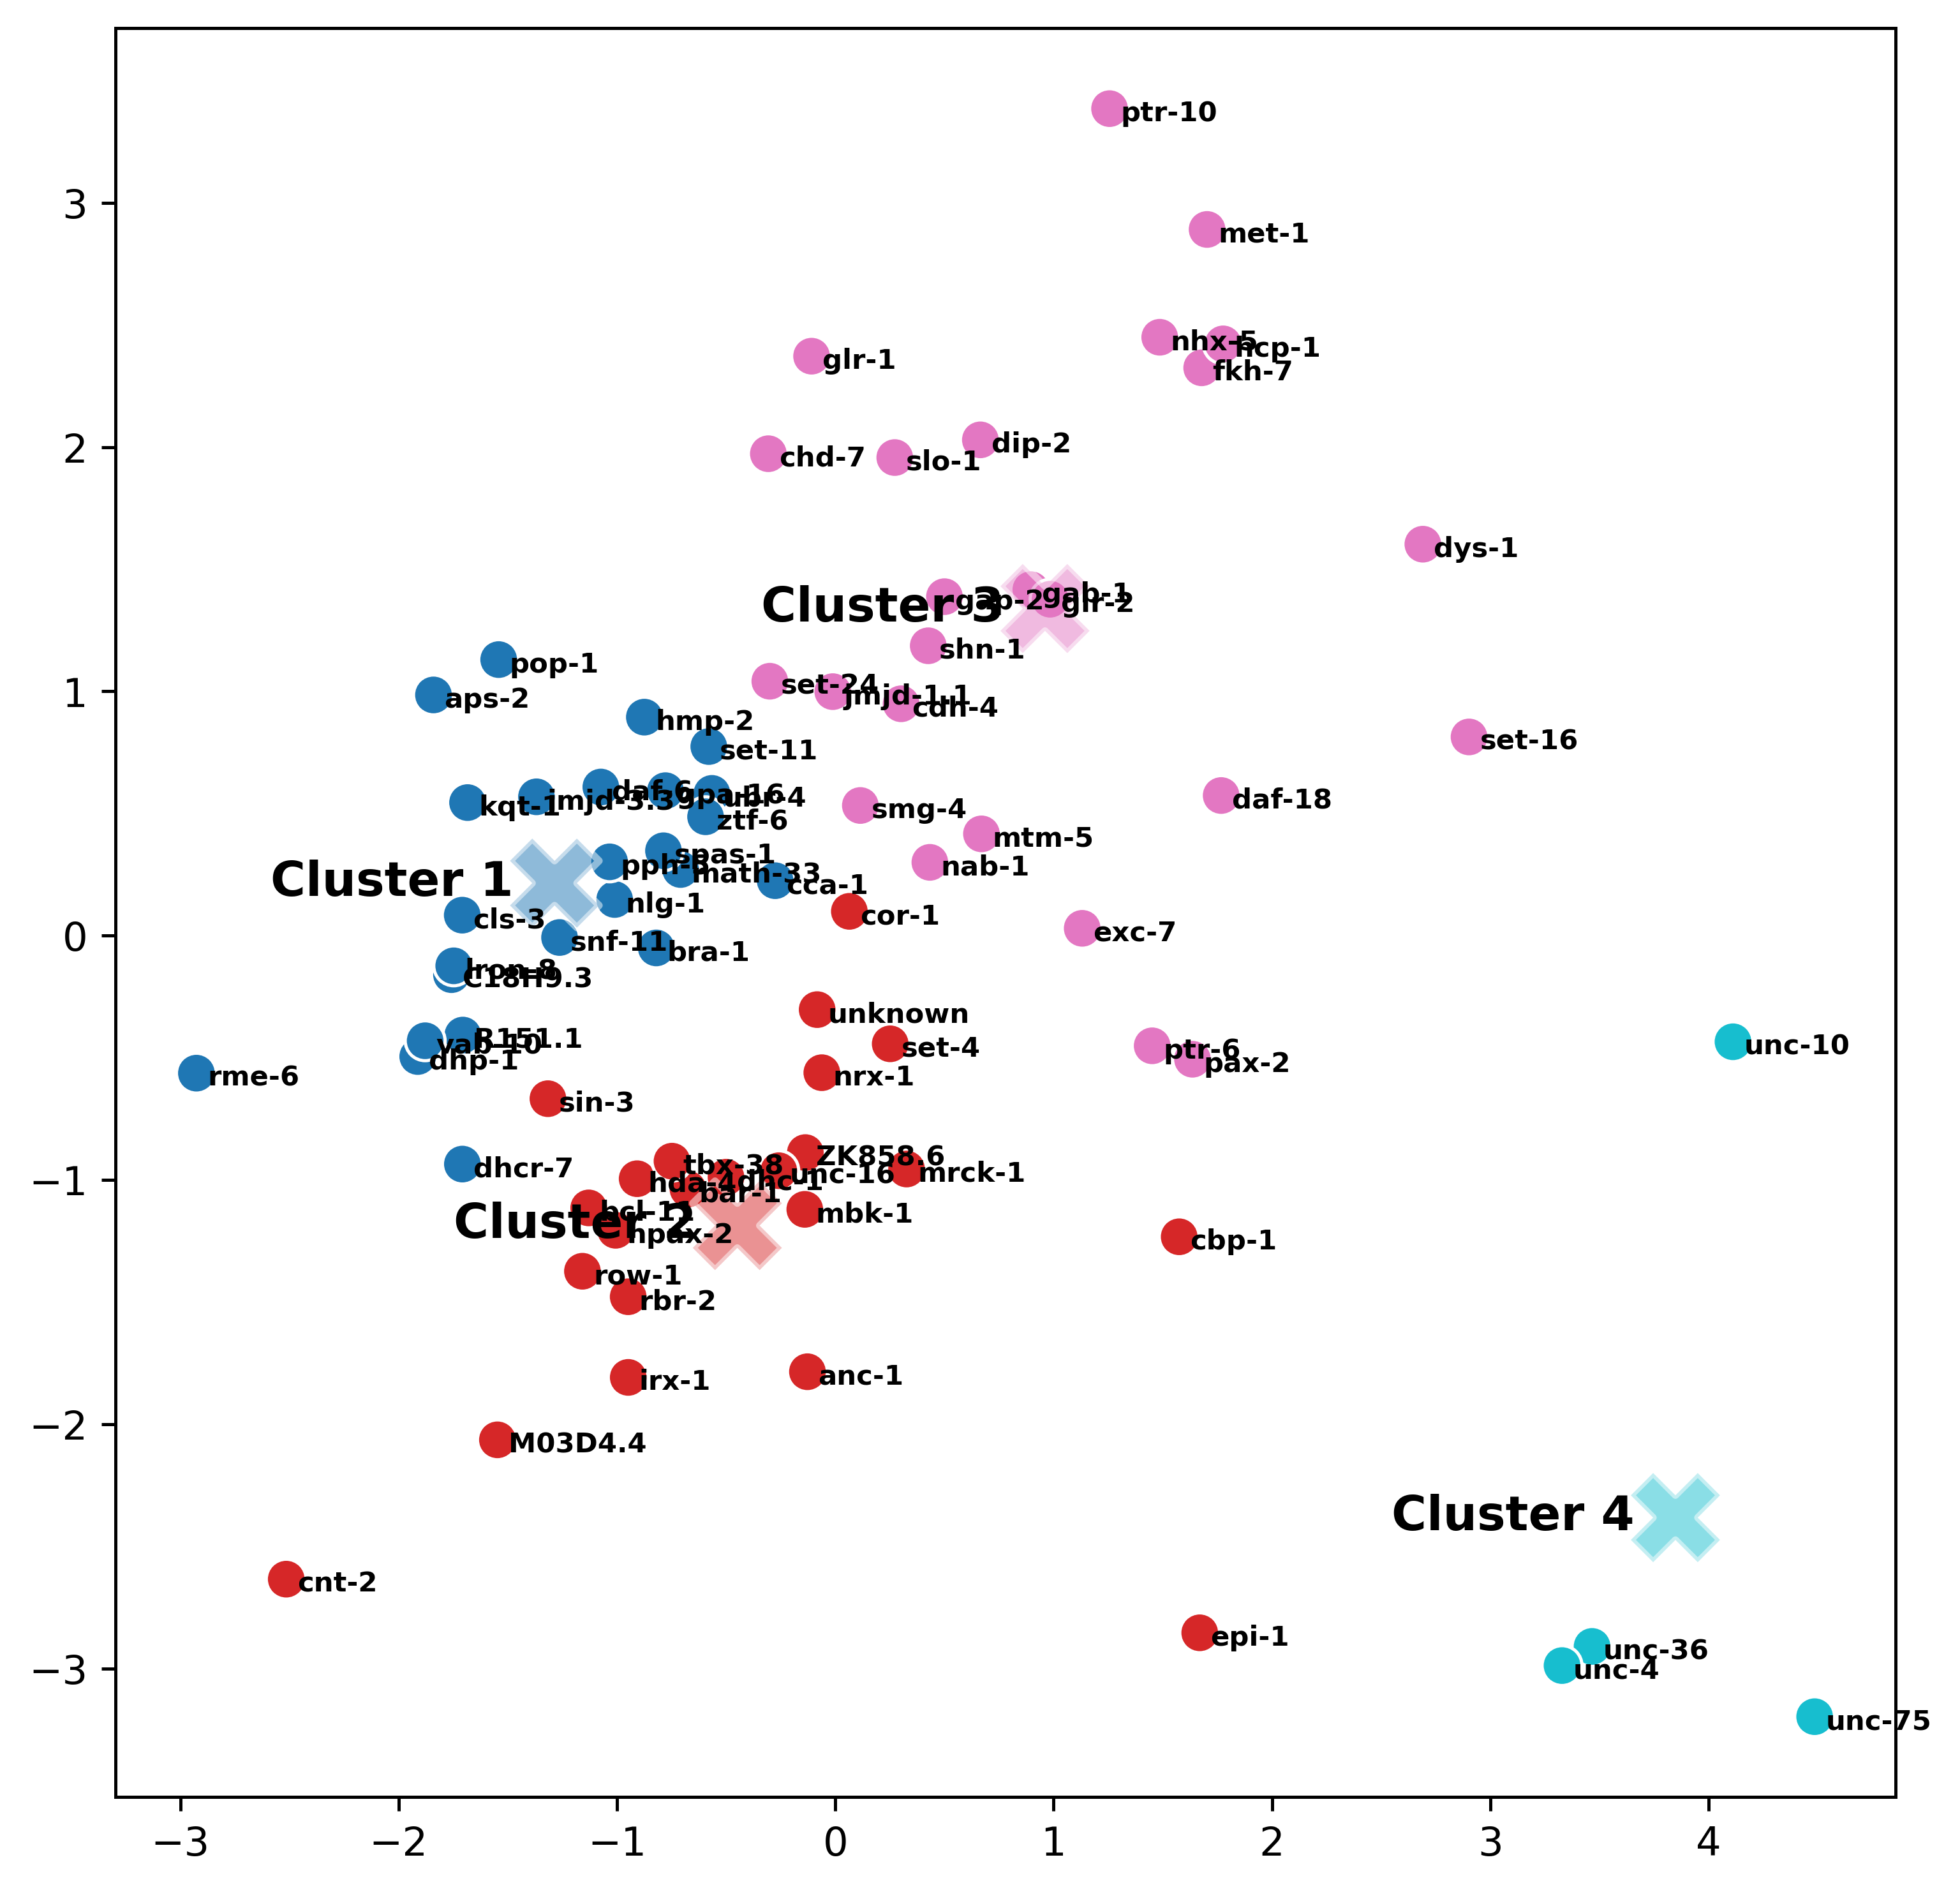

In [469]:
fig, axs = plt.subplots(figsize=(8, 8), dpi=450)

sns.scatterplot(data=df_PCA_dropped, x="PCA_x", y="PCA_y", hue="KMeans", legend=False, palette = my_palette, s=100)

def label_marker(x, y, val, ax, markersize):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+0.05, point['y']-0.05, str(point['val']), fontsize = markersize, weight='bold')

label_marker(df_PCA_dropped.PCA_x, df_PCA_dropped.PCA_y, df_PCA_dropped.Gene, plt.gca(), 'x-small') 

# sns.scatterplot(data=df_PCA_others, x="PCA_x", y="PCA_y", c='k',legend=False, alpha = 0.2)

sns.scatterplot(data=df_clusters, x="PCA_x", y="PCA_y", hue="Clusters", legend=False, palette = ['#1f77b4', '#d62728', '#e377c2', '#17becf'], marker='X',s=500, alpha = 0.5)
# 

def label_point(x, y, val, ax, markersize):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']-1.3, point['y']-0.05, str(point['val']), fontsize = markersize, weight='bold')
        
label_point(df_clusters.PCA_x, df_clusters.PCA_y, df_clusters.Clusters, plt.gca(), 'large') 

axs.set_title("")
axs.set_xlabel("")
axs.set_ylabel("")



plt.savefig('/Users/Joseph/Desktop/ASD_PCA_Cluster_New.png', bbox_inches='tight')
plt.show()



In [421]:
Gene_KMeans = df_PCA_dropped[['KMeans','Gene']]

Gene_KMeans = Gene_KMeans.rename(columns={"KMeans":"Cluster"})

Gene_KMeans['Cluster'] = Gene_KMeans['Cluster'] + 1

print(Gene_KMeans)

Gene_KMeans.to_csv('/Users/Joseph/Desktop/ASD_Clustered_Gene_New_SorryLexi.csv')

    Cluster     Gene
0         1  C18H9.3
1         2  M03D4.4
2         1   R151.1
3         2  ZK858.6
4         2    anc-1
..      ...      ...
72        4    unc-4
73        4   unc-75
74        2  unknown
75        1   vab-10
76        1    ztf-6

[77 rows x 2 columns]


In [97]:
# from plotly.subplots import make_subplots
# import plotly.express as px
# import plotly.graph_objects as go

# fig = make_subplots(cols=2, rows=2,
#                     specs=[[{"type": "polar"} for _ in range(2)] for _ in range(2)],
#                     # subplot_titles=("Cluster 1", "Cluster 2", "Cluster 3", "Cluster 4", "Cluster 5")
#                    )


# fig.add_trace(
#     go.Scatterpolar(r = centers.iloc[0], theta = centers.columns, fill="toself",name="(Cluster 1)"),
#     row=1, col=1
# )


# fig.add_trace(
#     go.Scatterpolar(r = centers.iloc[1], theta = centers.columns, fill="toself",name="(Cluster 2)"),
#     row=1, col=2
# )

# fig.add_trace(
#     go.Scatterpolar(r = centers.iloc[2], theta = centers.columns, fill="toself",name="(Cluster 3)"),
#     row=2, col=1
# )

# fig.add_trace(
#     go.Scatterpolar(r = centers.iloc[3], theta = centers.columns, fill="toself",name="(Cluster 4)"),
#     row=2, col=2
# )



# fig.update_layout(
#   polar=dict(
#     radialaxis=dict(
#       visible=True
#     ),
#   ),
#   showlegend=False
# )

# fig.update_layout(height=1500, width=1000, template='plotly_dark',title_text="5 'Profiles' associated with PD genotype")
# fig.update_polars(radialaxis=dict(range=[-3, 3]))
# fig.show()

In [141]:
# centers.loc[row].values.flatten().tolist()
# list(centers)[0:]
# cols=['Habituation of Response Duration','Bias','Kink','Final Response Probability','Curve','Instantaneous Speed','Width']
# centers=centers[cols]
centers

Bias  Initial Response Probability  Final Response Duration  \
0 -0.453180                     -0.231775                -0.149084   
1  0.115763                     -0.218503                 0.028238   
2  1.630024                      0.050541                -0.075520   
3  0.693398                     -2.464886                -1.865361   

   Habituation of Response Speed     Width  Initial Response Duration  \
0                      -1.154063 -0.970496                  -0.160366   
1                      -0.424975  0.176902                   0.475450   
2                       1.133375 -0.331971                   0.341554   
3                      -0.542627 -0.617879                  -1.815556   

   Initial Response Speed  
0               -0.844431  
1                0.076224  
2                0.734251  
3               -1.736686

In [436]:
centers_reorg=centers[['Habituation of Response Speed',
              'Area',
             'Bias',
             'Aspect Ratio',
             'Crab',
             'Initial Response Duration',
             'Final Response Duration']]

centers_reorg

Habituation of Response Speed      Area      Bias  Aspect Ratio      Crab  \
0                      -0.606520  0.035461 -0.076209     -0.214433 -0.148260   
1                      -1.150365 -0.992930 -0.511036      0.031442 -0.016067   
2                       0.579063 -0.502716  1.334713      0.185013  1.286526   
3                      -0.550172 -2.412233  0.342768      3.389685  1.313554   

   Initial Response Duration  Final Response Duration  
0                   0.690037                 0.201589  
1                  -0.498451                -0.282566  
2                   0.053155                -0.270741  
3                  -1.491987                -2.613749

In [433]:
categories = ['Habituation of Response Speed',
              'Area',
             'Bias',
             'Aspect Ratio',
             'Crab',
             'Initial Response Duration',
             'Final Response Duration']


categories

['Habituation of Response Speed',
 'Area',
 'Bias',
 'Aspect Ratio',
 'Crab',
 'Initial Response Duration',
 'Final Response Duration']

/var/folders/31/jpj6mpsx60d9829cymplqfsh0000gn/T/ipykernel_15027/77439305.py:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  my_palette = plt.cm.get_cmap("tab10", len(centers.index))


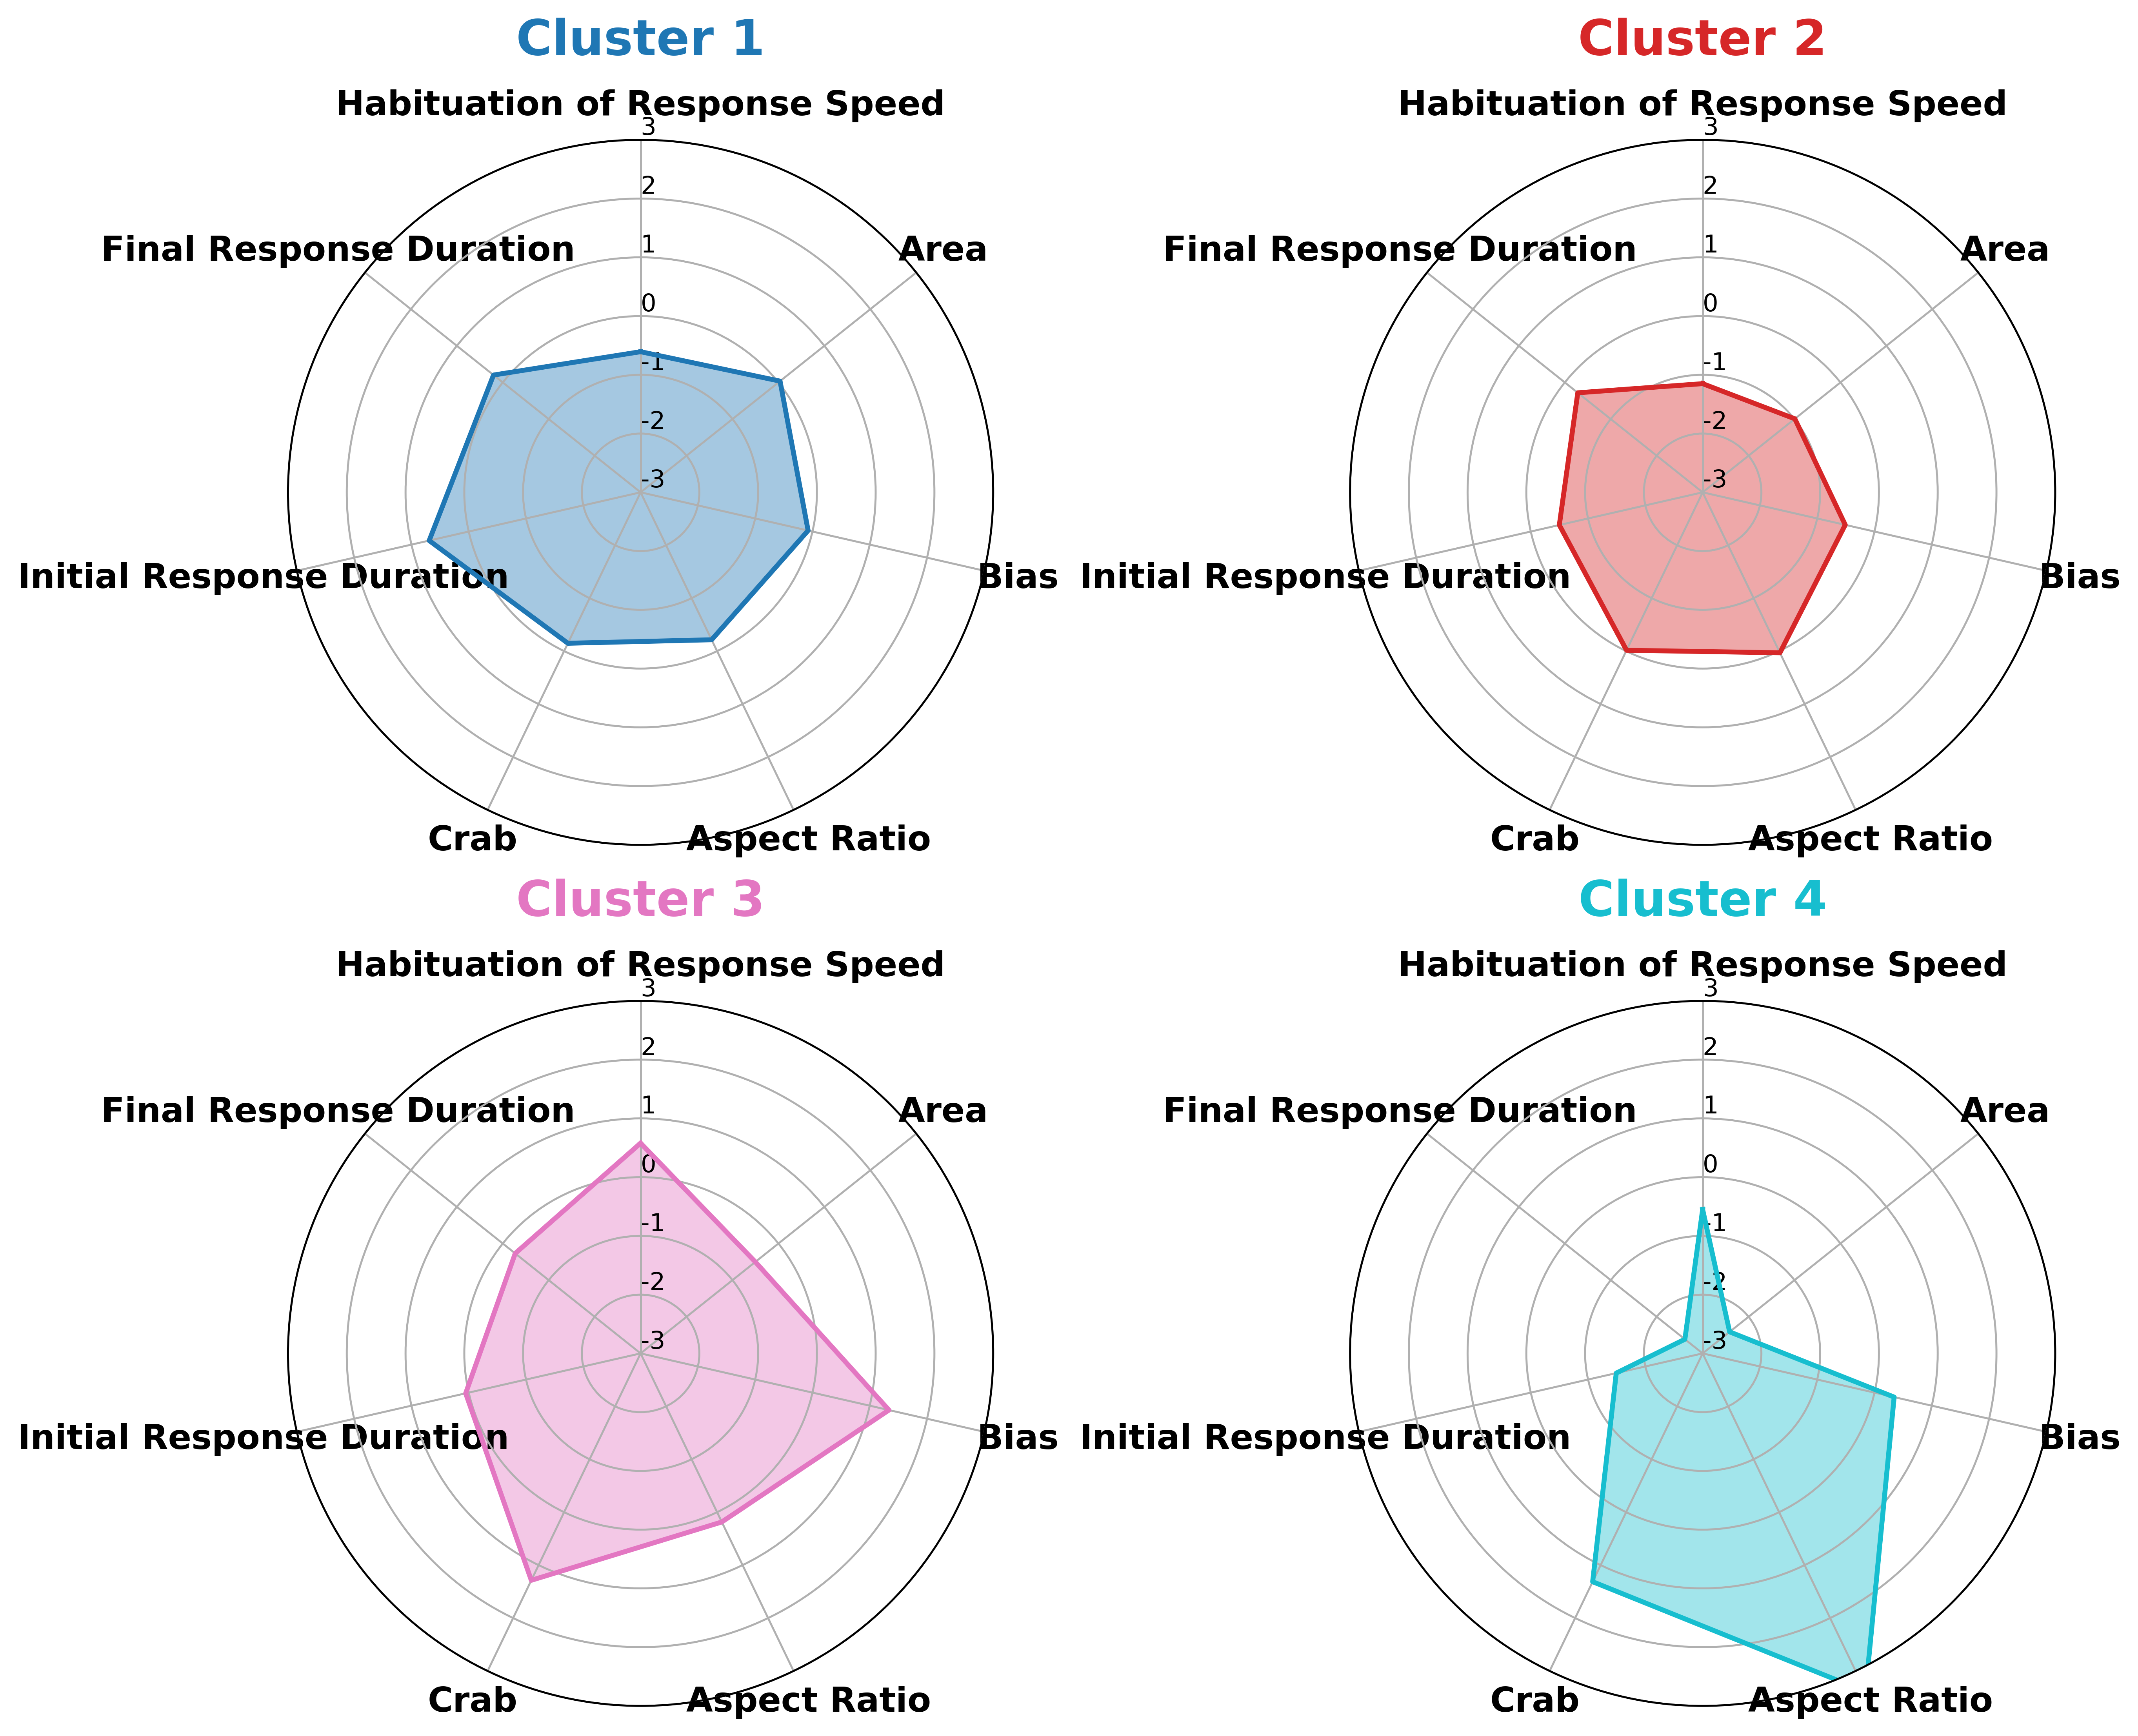

In [448]:
# Libraries
import matplotlib.pyplot as plt
import pandas as pd
from math import pi
import matplotlib
 
 
# ------- PART 1: Define a function that do a plot for one line of the dataset!
 
def make_spider(row, title, color):

    # number of variable
    categories=list(centers_reorg)[0:]
    N = len(categories)

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Initialise the spider plot
    ax = plt.subplot(2,2,row+1, polar=True, )

    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories, color='k', size=14, weight = 'bold')

    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([-5,-4,-3,-2,-1,0,1,2,3,4,5], ["-5","-4","-3","-2","-1","0","1","2","3","4","5"], color="k", size=10)
    plt.ylim(-3,3)

    # Ind1
    values=centers_reorg.loc[row].values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
    ax.fill(angles, values, color=color, alpha=0.4)

    # Add a title
    plt.title(title, size=20, color=color, y=1.1, weight='bold')

    
# ------- PART 2: Apply the function to all individuals
# initialize the figure
my_dpi=450
plt.figure(figsize=(12, 12), dpi=my_dpi, layout='compressed')
# Create a color palette:
my_palette = plt.cm.get_cmap("tab10", len(centers.index))
 
# Loop to plot
for row in range(0, len(centers.index)):
    make_spider(row=row, title='Cluster '+str(centers_reorg.index[row]+1), color=my_palette(row))
plt.savefig('/Users/Joseph/Desktop/ASD_ClusterProfiles_New_Sorry_Lexi.png', bbox_inches='tight')
plt.show()

### Stopped Here...

## Plotting Individual Genotypes

In [453]:
feature_list = ['Habituation of Response Speed',
              'Area',
             'Bias',
             'Aspect Ratio',
             'Crab',
             'Initial Response Duration',
             'Final Response Duration']

feature_list_with_gene = ['Gene',
                          'Habituation of Response Speed',
                          'Area',
                         'Bias',
                         'Aspect Ratio',
                         'Crab',
                         'Initial Response Duration',
                         'Final Response Duration']
PD_Screen_plot = PD_Screen[feature_list_with_gene]

cols=feature_list_with_gene
PD_Screen_plot=PD_Screen_plot[cols]
PD_Screen_plot

Gene  Habituation of Response Speed      Area      Bias  Aspect Ratio  \
0   C18H9.3                      -0.852143  0.435323 -0.906314     -0.115086   
1   M03D4.4                      -2.570717 -0.629753 -1.528013     -0.026771   
3    R151.1                      -1.062773 -0.581830 -0.672784      0.274941   
4   ZK858.6                      -1.131573 -0.659422  0.053918      0.233398   
5     anc-1                      -1.584807 -1.739887 -0.519592      0.825648   
..      ...                            ...       ...       ...           ...   
73    unc-4                      -1.144794 -0.283482 -0.168112      3.886903   
74   unc-75                       0.043558 -4.700223 -0.038110      1.955491   
75  unknown                      -0.671497 -1.523966  0.075470     -0.300840   
76   vab-10                      -0.970456  0.478454 -0.610486     -0.026438   
77    ztf-6                      -0.782507 -0.589301  0.977324     -0.564990   

        Crab  Initial Response Duration  Final Response Duration  
0  -0.021343                   0.700340                 0.374578  
1   0.011223                   0.379903                -0.439289  
3  -0.566572                   0.377571                 1.459391  
4   0.098777                  -0.432375                -0.551079  
5  -0.271745                  -0.450722                -0.085498  
..       ...                        ...                      ...  
73  1.289144                  -3.119062                -2.117566  
74  1.042288                  -2.689913                -3.108427  
75  0.462820                  -0.060101                -0.036111  
76 -0.762457                   0.421469                 0.288109  
77  0.107241                   0.162337                 0.285350  

[77 rows x 8 columns]

In [454]:
PD_Screen_cluster = PD_Screen[feature_list_with_gene]
PD_Screen_cluster['Cluster'] = kmeans.labels_
PD_Screen_cluster.head()

/var/folders/31/jpj6mpsx60d9829cymplqfsh0000gn/T/ipykernel_15027/3515481841.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PD_Screen_cluster['Cluster'] = kmeans.labels_


Gene  Habituation of Response Speed      Area      Bias  Aspect Ratio  \
0  C18H9.3                      -0.852143  0.435323 -0.906314     -0.115086   
1  M03D4.4                      -2.570717 -0.629753 -1.528013     -0.026771   
3   R151.1                      -1.062773 -0.581830 -0.672784      0.274941   
4  ZK858.6                      -1.131573 -0.659422  0.053918      0.233398   
5    anc-1                      -1.584807 -1.739887 -0.519592      0.825648   

       Crab  Initial Response Duration  Final Response Duration  Cluster  
0 -0.021343                   0.700340                 0.374578        0  
1  0.011223                   0.379903                -0.439289        1  
3 -0.566572                   0.377571                 1.459391        0  
4  0.098777                  -0.432375                -0.551079        1  
5 -0.271745                  -0.450722                -0.085498        1

In [455]:
cols=['Gene',
      'Habituation of Response Speed',
      'Area',
     'Bias',
     'Aspect Ratio',
     'Crab',
     'Initial Response Duration',
     'Final Response Duration','Cluster']
PD_Screen_cluster=PD_Screen_cluster[cols]
PD_Screen_cluster

Gene  Habituation of Response Speed      Area      Bias  Aspect Ratio  \
0   C18H9.3                      -0.852143  0.435323 -0.906314     -0.115086   
1   M03D4.4                      -2.570717 -0.629753 -1.528013     -0.026771   
3    R151.1                      -1.062773 -0.581830 -0.672784      0.274941   
4   ZK858.6                      -1.131573 -0.659422  0.053918      0.233398   
5     anc-1                      -1.584807 -1.739887 -0.519592      0.825648   
..      ...                            ...       ...       ...           ...   
73    unc-4                      -1.144794 -0.283482 -0.168112      3.886903   
74   unc-75                       0.043558 -4.700223 -0.038110      1.955491   
75  unknown                      -0.671497 -1.523966  0.075470     -0.300840   
76   vab-10                      -0.970456  0.478454 -0.610486     -0.026438   
77    ztf-6                      -0.782507 -0.589301  0.977324     -0.564990   

        Crab  Initial Response Duration  Final Response Duration  Cluster  
0  -0.021343                   0.700340                 0.374578        0  
1   0.011223                   0.379903                -0.439289        1  
3  -0.566572                   0.377571                 1.459391        0  
4   0.098777                  -0.432375                -0.551079        1  
5  -0.271745                  -0.450722                -0.085498        1  
..       ...                        ...                      ...      ...  
73  1.289144                  -3.119062                -2.117566        3  
74  1.042288                  -2.689913                -3.108427        3  
75  0.462820                  -0.060101                -0.036111        1  
76 -0.762457                   0.421469                 0.288109        0  
77  0.107241                   0.162337                 0.285350        0  

[77 rows x 9 columns]

In [456]:
PD_Screen_plot['Gene'][0]

PD_Screen_plot.Gene[PD_Screen_plot.Gene == 'C29E4.10'].index

Index([], dtype='int64')

In [457]:
import ipywidgets as widgets

Gene_Dropdown = widgets.Dropdown(
                    options=list(PD_Screen_plot['Gene']),
                    value=PD_Screen_plot['Gene'][0],
                    description='Gene:',
                    disabled=False,
                )
display(Gene_Dropdown)

Dropdown(description='Gene:', options=('C18H9.3', 'M03D4.4', 'R151.1', 'ZK858.6', 'anc-1', 'aps-2', 'bar-1', '…

In [480]:
PD_Screen_cluster.loc[PD_Screen_cluster.Gene[PD_Screen_cluster.Gene == Gene_Dropdown.value].index].values.flatten().tolist()[:]

['bar-1',
 -1.2076057620622844,
 -0.5260369971818482,
 -0.6807204827107922,
 0.22459490355937528,
 0.1421129716282306,
 -0.26031330201546826,
 -0.1117500925857513,
 1]

In [481]:
PD_Screen_plot.loc[PD_Screen_plot.Gene[PD_Screen_plot.Gene == Gene_Dropdown.value].index].values.flatten().tolist()[:]

['bar-1',
 -1.2076057620622844,
 -0.5260369971818482,
 -0.6807204827107922,
 0.22459490355937528,
 0.1421129716282306,
 -0.26031330201546826,
 -0.1117500925857513]

In [117]:

# # number of variable
# categories=list(PD_Screen_plot)[1:]
# N = len(categories)
 
# # We are going to plot the first line of the data frame.
# # But we need to repeat the first value to close the circular graph:
# values=PD_Screen_plot.loc[PD_Screen_plot.Gene[PD_Screen_plot.Gene == Gene_Dropdown.value].index].values.flatten().tolist()[1:]
# values += values[:1]
# values
 
# # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
# angles = [n / float(N) * 2 * pi for n in range(N)]
# angles += angles[:1]
 
# # Initialise the spider plot
# ax = plt.subplot(111, polar=True)

# # If you want the first axis to be on top:
# ax.set_theta_offset(pi / 2)
# ax.set_theta_direction(-1)

# # Draw one axe per variable + add labels
# plt.xticks(angles[:-1], categories, color='grey', size=8)



# # Draw ylabels
# ax.set_rlabel_position(0)
# plt.yticks([-5,-4,-3,-2,-1,0,1,2,3,4,5], ["-5","-4","-3","-2","-1","0","1","2","3","4","5"], color="grey", size=7)
# plt.ylim(-4,4)
 
# # Plot data
# ax.plot(angles, values, linewidth=1, linestyle='solid')
 
# # Fill area
# ax.fill(angles, values, 'b', alpha=0.2)

# # Show the graph
# plt.show()

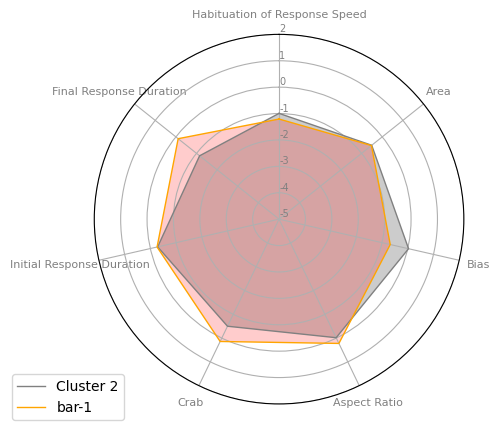

In [482]:
# ------- PART 1: Create background
 
# number of variable
categories=list(PD_Screen_plot)[1:]
N = len(categories)
 
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
 
# Initialise the spider plot
ax = plt.subplot(111, polar=True)
 
# If you want the first axis to be on top:
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
 
# Draw one axe per variable + add labels
plt.xticks(angles[:-1], categories, color='grey', size=8)

 
# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([-5,-4,-3,-2,-1,0,1,2,3,4,5], ["-5","-4","-3","-2","-1","0","1","2","3","4","5"], color="grey", size=7)
plt.ylim(-5,2)
 

# ------- PART 2: Add plots
 
# Plot each individual = each line of the data
# I don't make a loop, because plotting more than 3 groups makes the chart unreadable
 
# Ind1
cluster_row = PD_Screen_cluster.loc[PD_Screen_cluster.Gene[PD_Screen_cluster.Gene == Gene_Dropdown.value].index].values.flatten().tolist()[-1]
values=centers.loc[cluster_row].values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', color="grey",label=f"Cluster {cluster_row+1}")
ax.fill(angles, values, 'grey', alpha=0.4)
 
# Ind2
values=PD_Screen_plot.loc[PD_Screen_plot.Gene[PD_Screen_plot.Gene == Gene_Dropdown.value].index].values.flatten().tolist()[1:]
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', color="orange",label=f"{Gene_Dropdown.value}")
ax.fill(angles, values, 'r', alpha=0.2)
 
# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

# Show the graph
# plt.savefig(f'/Users/Joseph/Desktop/{Gene_Dropdown.value}_profile.png', format='png', dpi=450, bbox_inches='tight')
plt.show()
# plt.savefig(f'/Users/Joseph/Desktop/NRSC510B/{Gene_Dropdown.value}_profile.png', format='png', dpi=450, bbox_inches='tight')